# <font color="F3E9DC" > **ML Project Winter 2025** </font>


<font color="bisque" > **Context : While training conventional machine learning models on oscillation data, a critical limitation emerges: these models often fail to capture damping effects, predicting perpetual oscillations. This discrepancy arises because purely data-driven approaches ignore underlying physical laws governing energy dissipation.** </font>


---

<font color="bisque"> **We will use physics-informed neural networks (PINNs)in order to overcome the damping prediction limitations of traditional ML models .**
</font>

---

<font color="bisque">-->>>
What lead us to use PINNS ?

1. <font color="bisque">Data-Driven Limitations: Standard ML models rely solely on training data . This does not completely represents physical phenomenan including friction and damping .</font>

2. <font color="bisque">Physics Ignorance : Traditional approaches also do not take into account equations , especially higher order equations that governs the phenomenan involved . In our case the equation being</font>


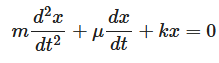
</font>


---



<font color="bisque"> **The initial conditions of our SHM being -**

*   **x(0) = 1**
*   **x'(0) [derivative of x wrt t at t=0 ] = 0** </font>


---
<font color="bisque"> **The conditions related to damping are given by the following equations->>**

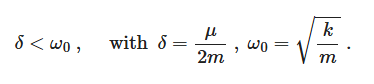


---
<font color="bisque"> **The exact solutions of the damped simple harmonic motion will be given by->>**

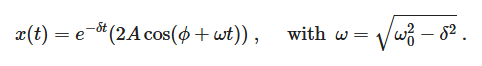



---






In [2]:
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


In [3]:
def oscillator(d, w0, x):

  """here 1. d  = damping coefficient
          2. w0 = natural frequency without damping
          3. x  = input variable (time) """

  assert d < w0            #Ensures the system is under-damped
  w = np.sqrt(w0**2-d**2)  #Calculation of damped frequency
  phi = np.arctan(-d/w)    #Phase difference in radians
  A = 1/(2*np.cos(phi))    #To ensure our intial condition of x(0)=1 is matched
  cos = torch.cos(phi+w*x)
  sin = torch.sin(phi+w*x)
  exp = torch.exp(-d*x)
  y  = exp*2*A*cos         #Final output of the position of particle after considering damping
  return y

<font color="bisque"> **Now we are going to define a FCN class . This will provide the basic architecture for the neural networks to function . Once we generate training data ; we will use the FCN architecture on both - a simple neural network and then a neural network with PINNS to illutrate the difference between them .** </font>


In [10]:
class FCN(nn.Module):

  def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
    # The constructor will work on the basis of 4 parameters ; number of input layers , output layers , number of neurons in each hidden layer and the total number of layers themselves . Self function will be used to call it .
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        # Defining the very first layer(input + activation ) .
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        # Defining the structure of every other layer that comes after the input layer . For rach layer we'll move between one hidden layer [ with the activation function ] .
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        #Defining the very last layer ; mapping the hidden layer to output layer [ WITHOUT ACTIVATION]

  def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
    # Forward function ; Basically your input data will move through all the layers in the network that we have structured earlier and finally give you the output.

<font color="bisque" > Questions pertaining to the Project -
1. Why did I specifically use tanh function in FCN and not other popular activation function like sigmoid , ReLU etc ?
<div> The answer lies in the nature of our problem . ReLU turns all negative values into zero and all linear for all positive values . Sigmoid outputs value between 0 and 1 . Both fall flat in the nature of our question where outputs between -1 to 1 would be the most desirable setting the stage for hyperbiolic tanh function.  </div>


 </font>

<hr color="bisque" > </hr>

<h1 color="bisque"> LETS GENERATE THE TRAINING DATA </h1>
<h5 color="bisque">  For our problem we will take the damping coefficient to be 3 and the natural frequency to be 24 ; d = 3 , w0 = 24 . </h5>

torch.Size([1224, 1]) torch.Size([1224, 1])
torch.Size([23, 1]) torch.Size([23, 1])


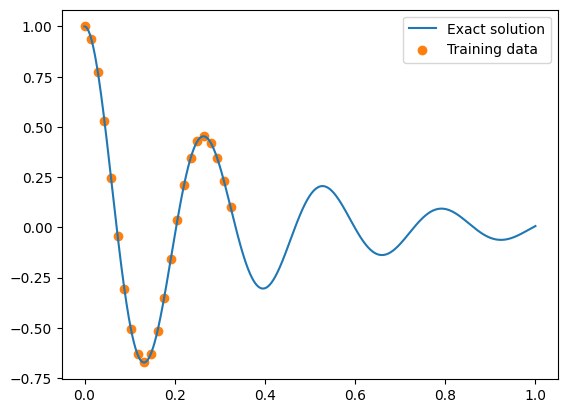

In [21]:
d, w0 = 3, 24

# get the analytical solution over the full domain
x = torch.linspace(0,1,1224).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain . here 12 datapoints (612/18 )
x_data = x[0:400:18]
y_data = y[0:400:18]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

<h1 color="bisque" > NORMAL NEURAL NETWORK </h1>
<h5 color="bisque"> The peculiar result that we will get from training our data on a neural network is that while the network can predict the points in the vicnity of the last few training data points . It falls flat for the ones after it.... </h5>

/tmp/ipython-input-25-621800333.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,4))


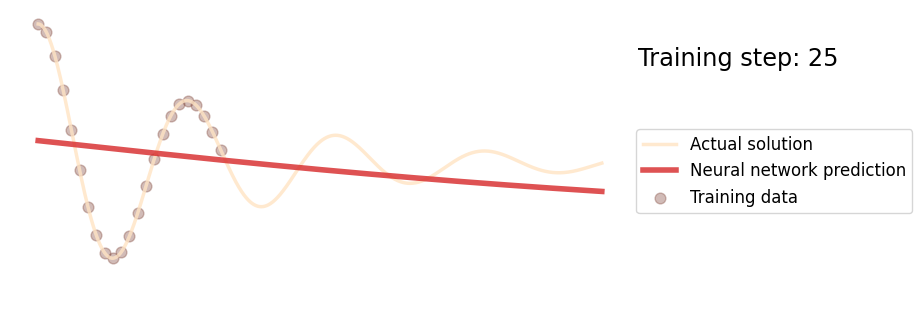

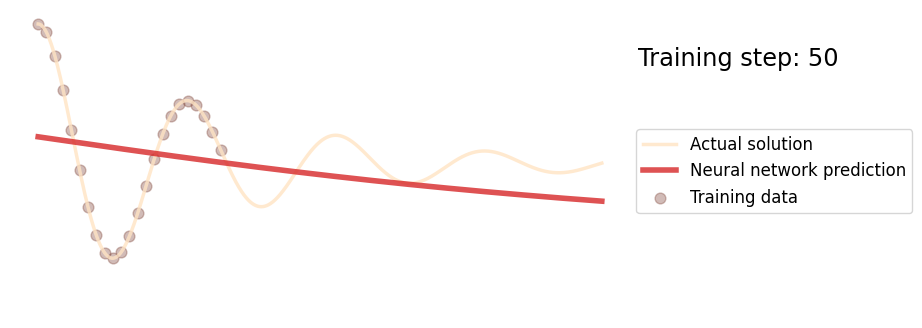

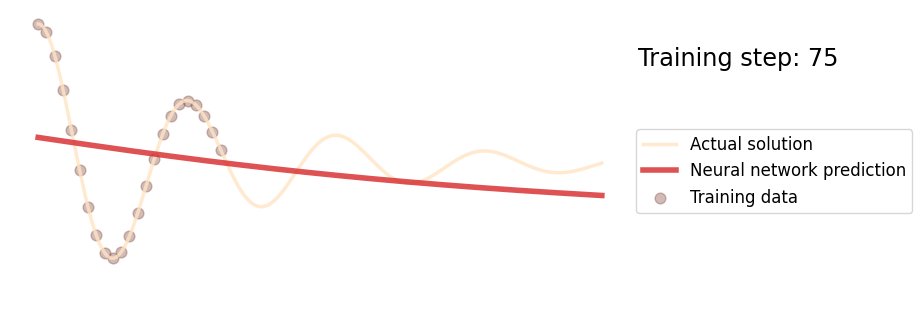

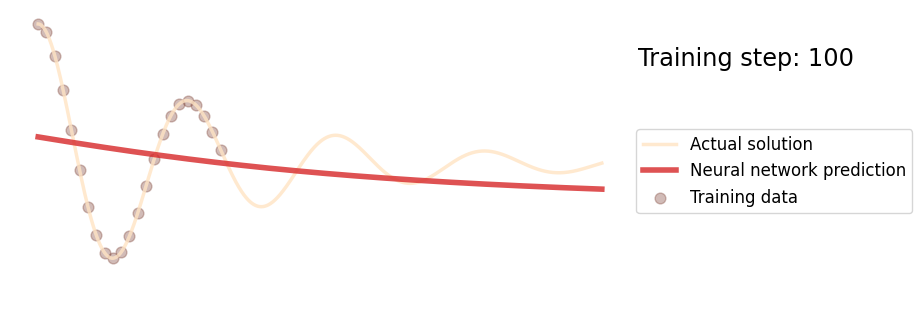

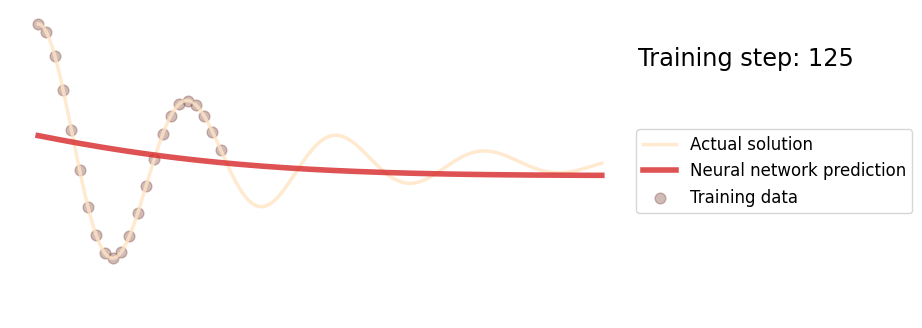

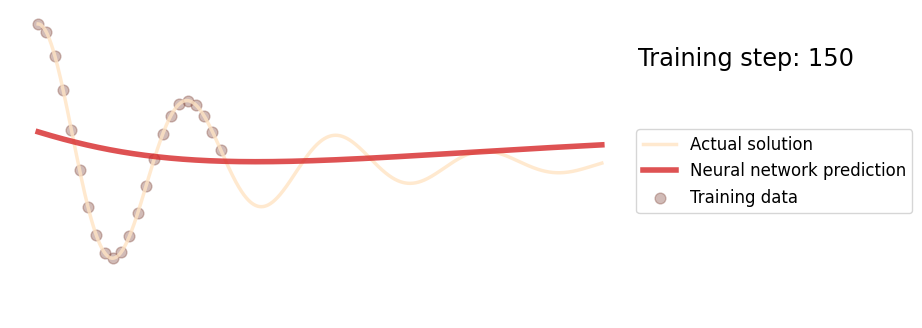

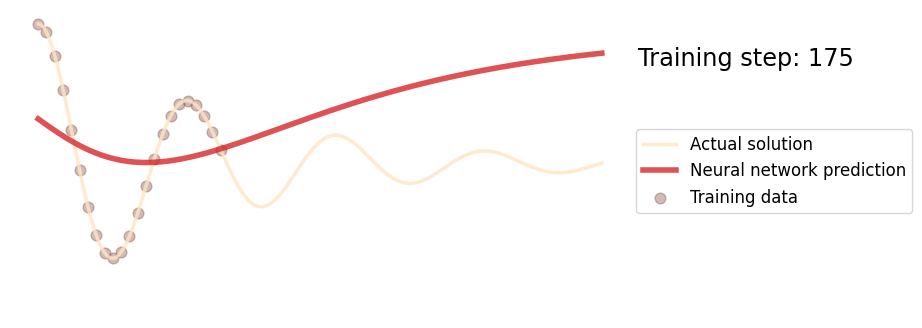

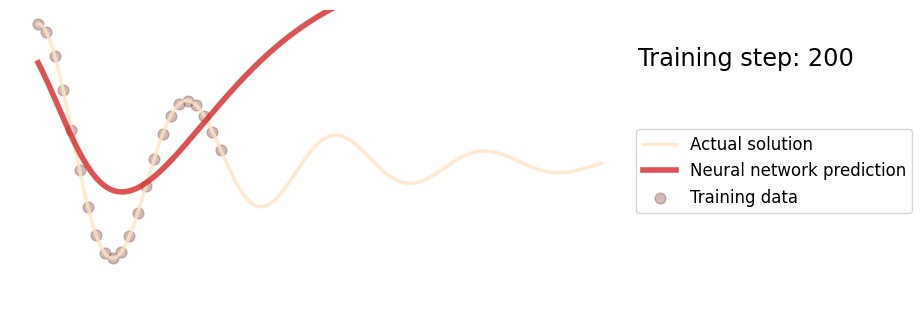

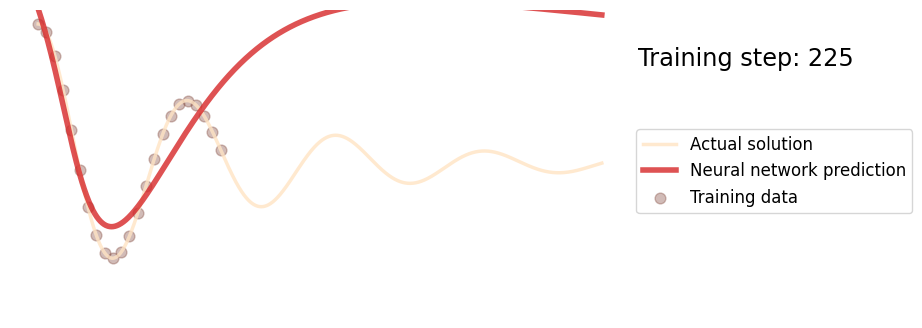

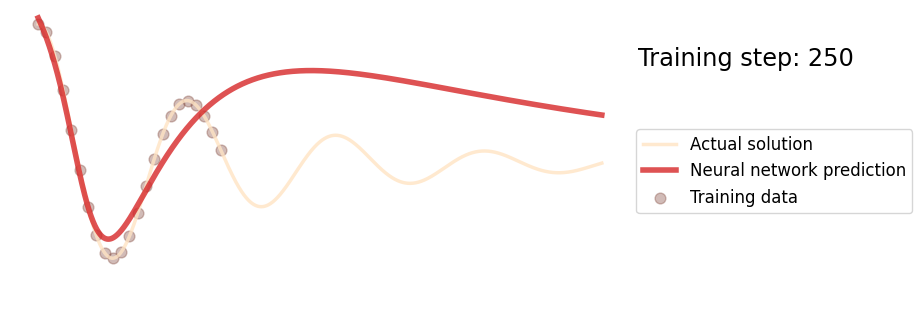

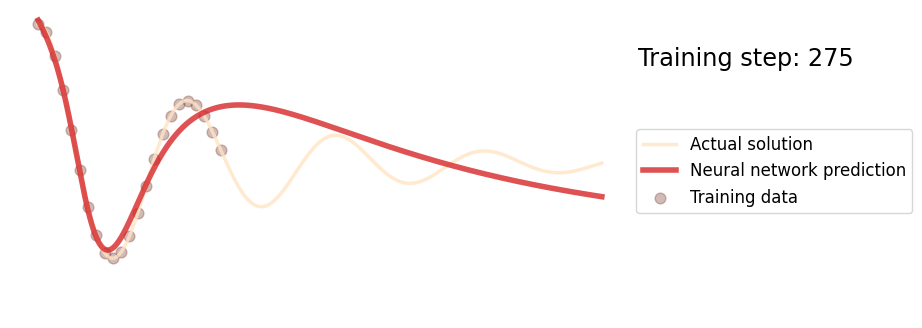

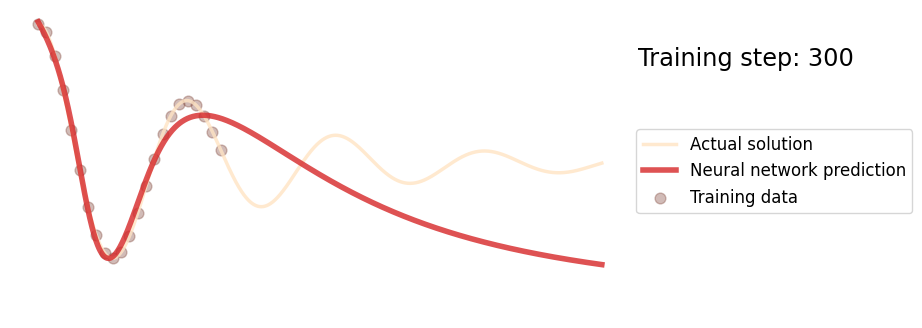

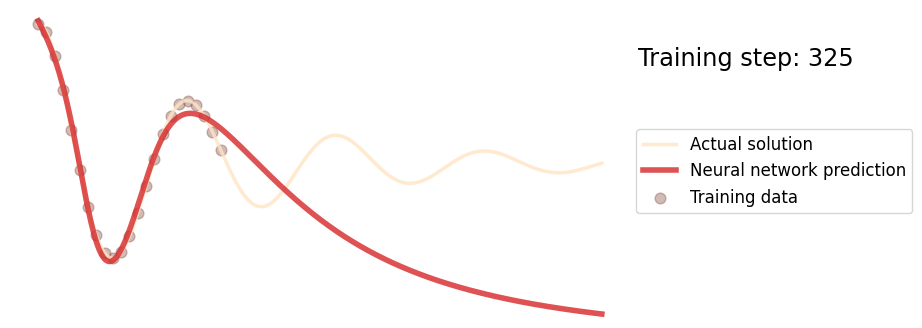

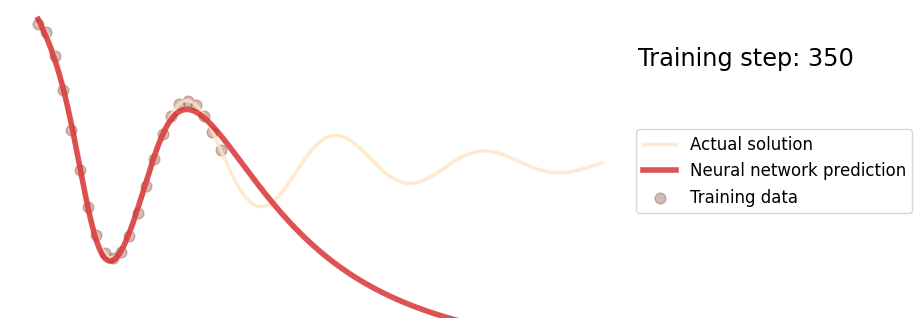

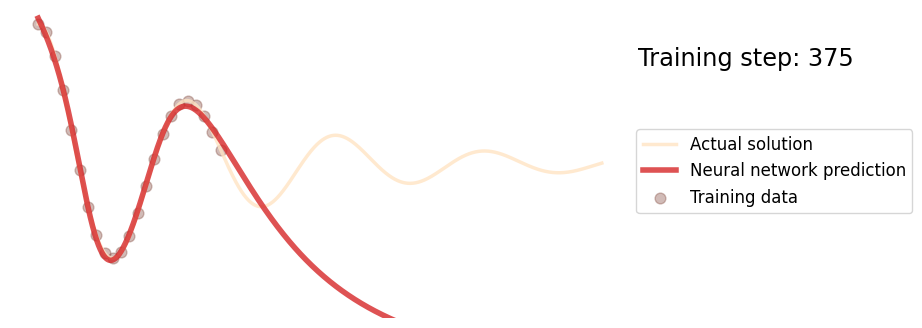

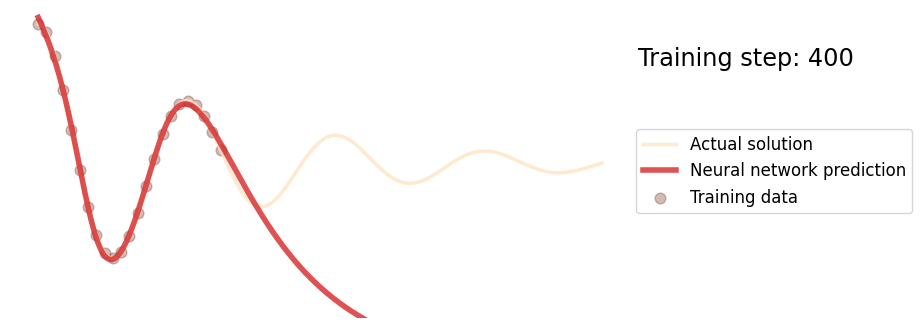

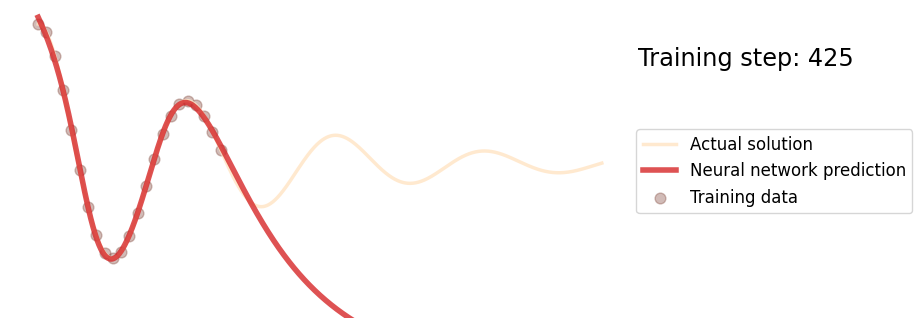

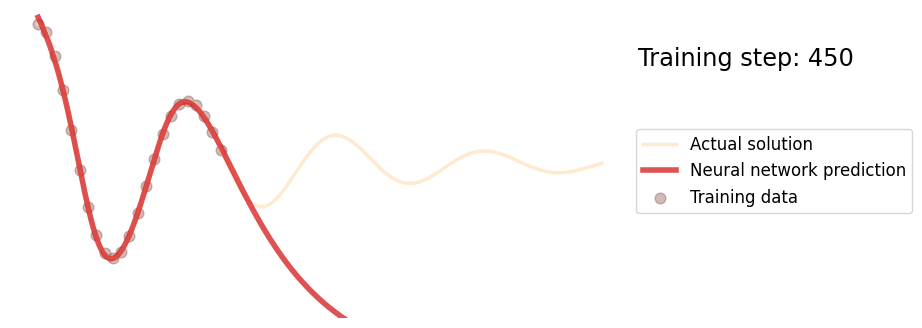

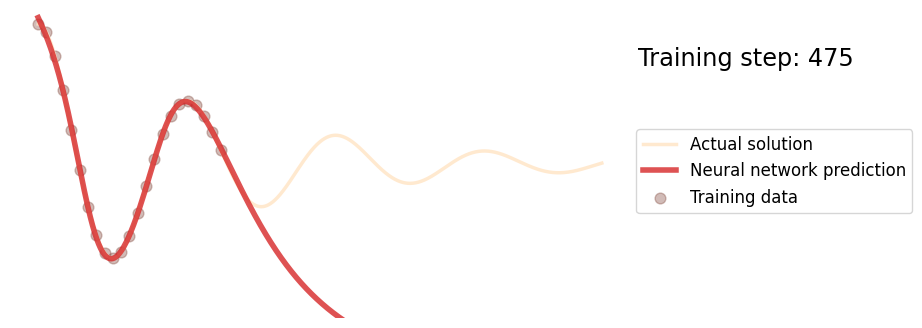

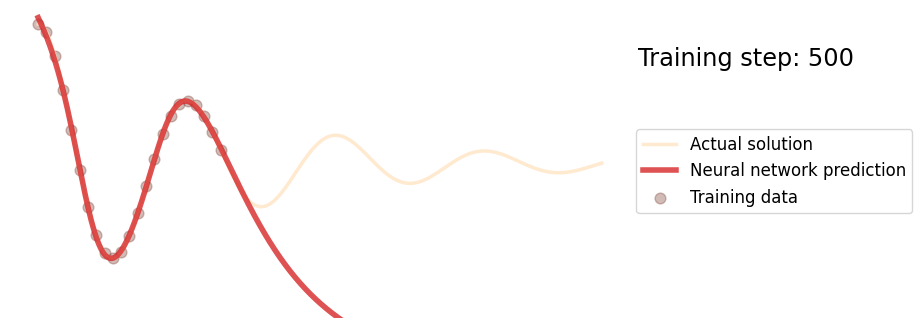

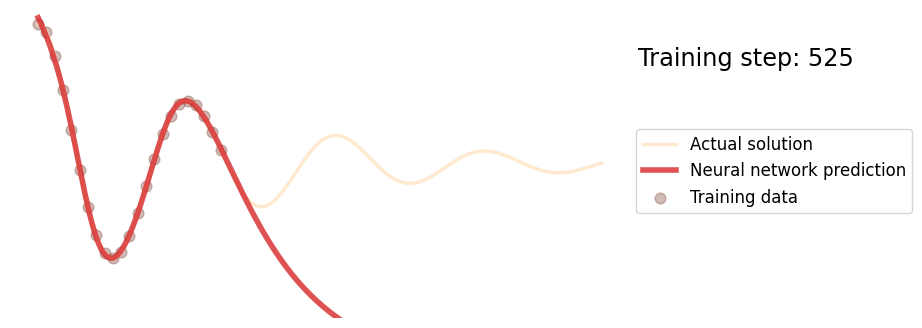

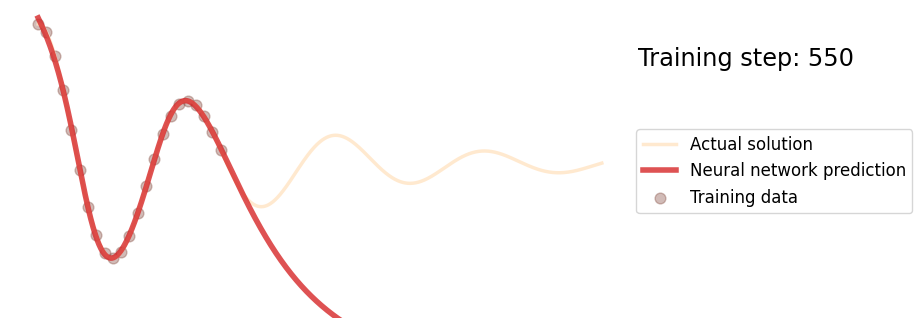

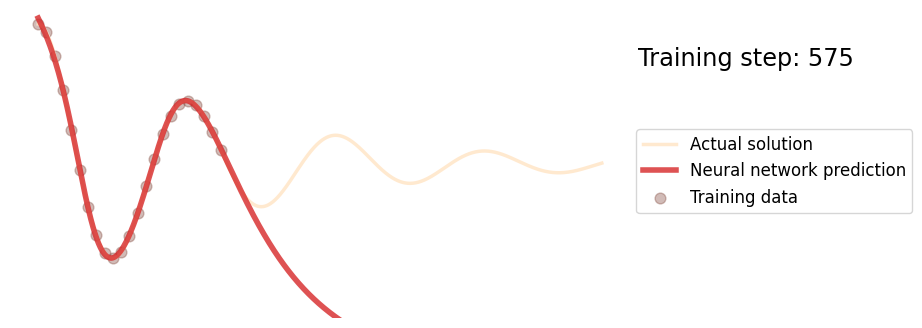

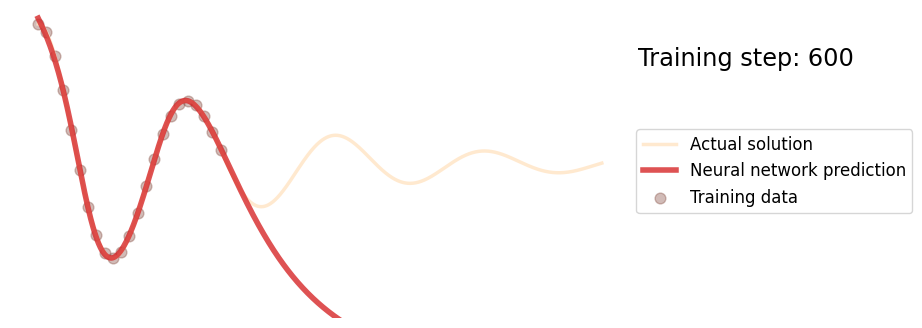

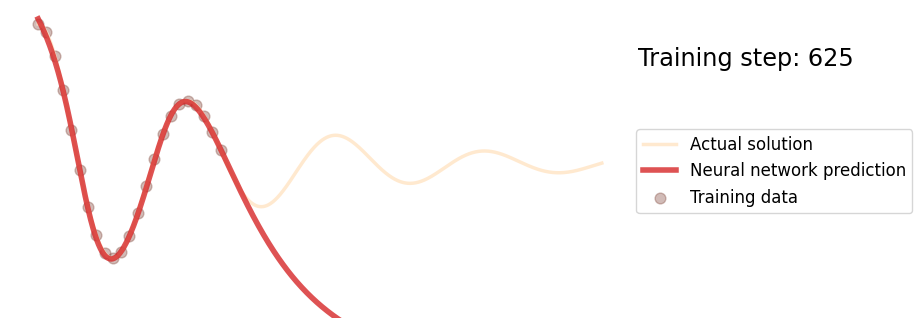

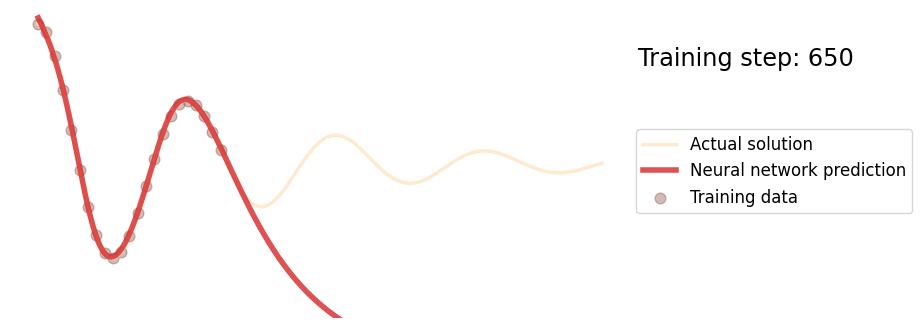

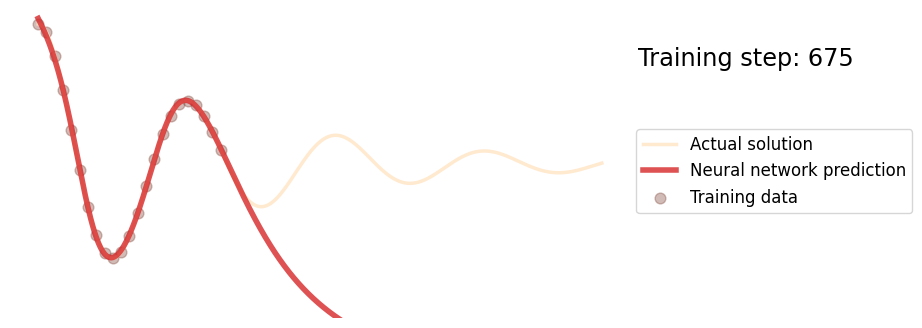

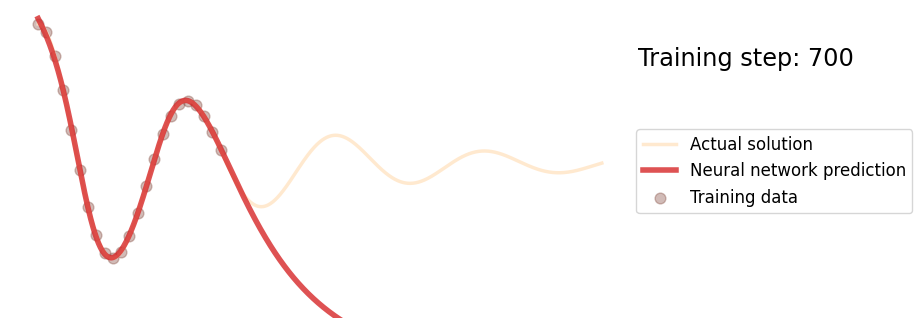

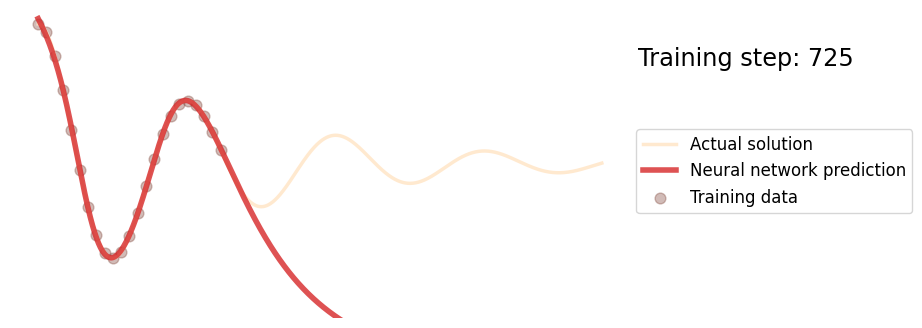

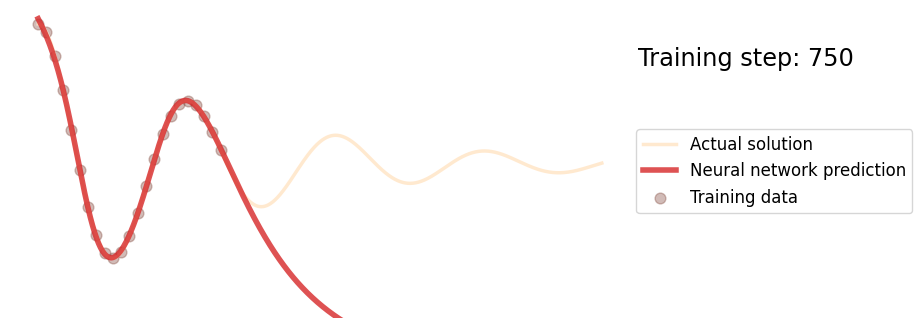

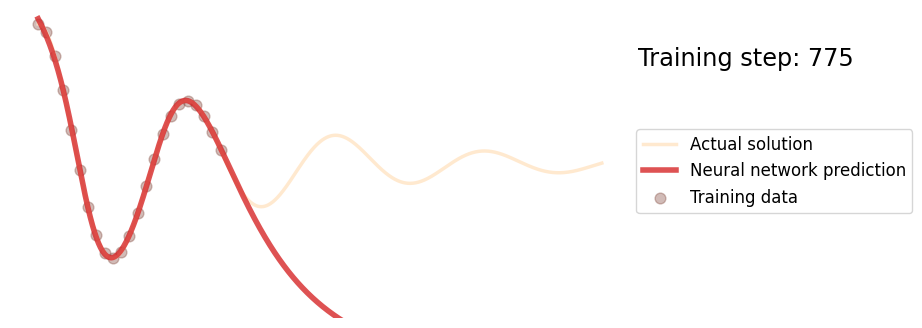

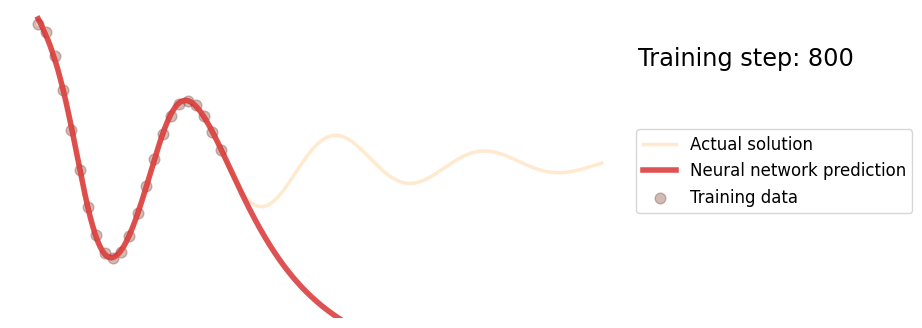

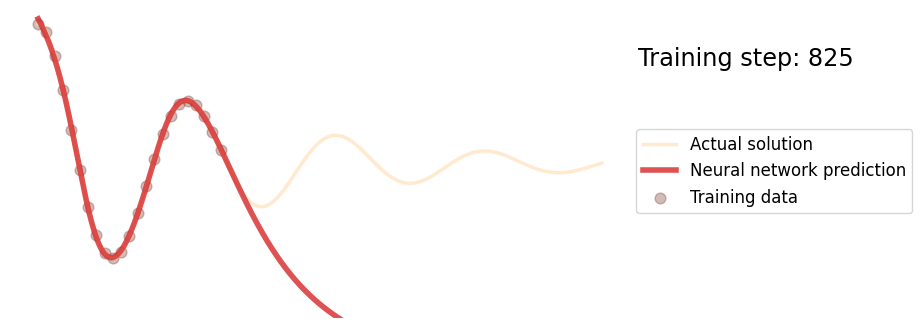

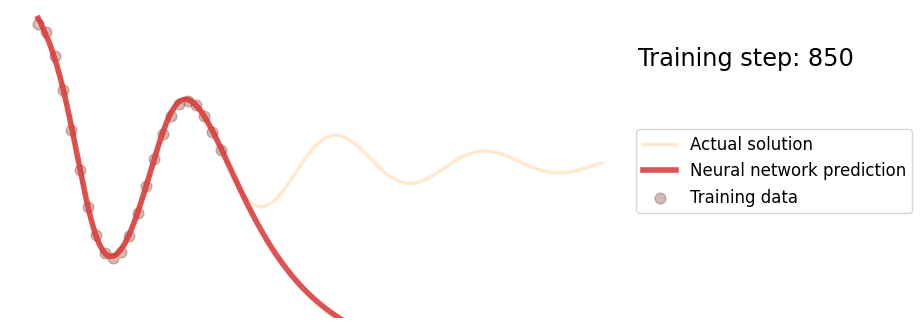

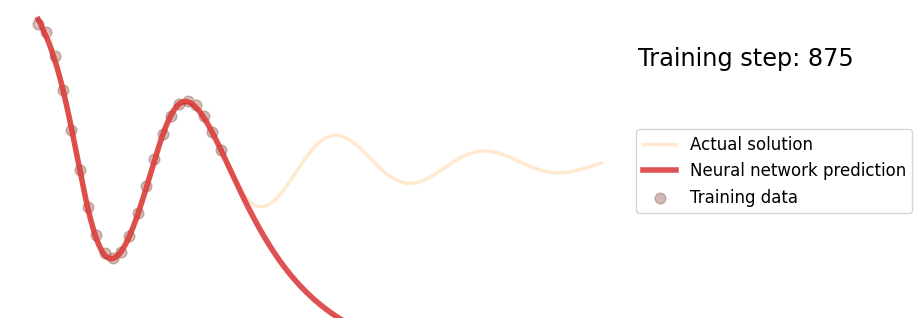

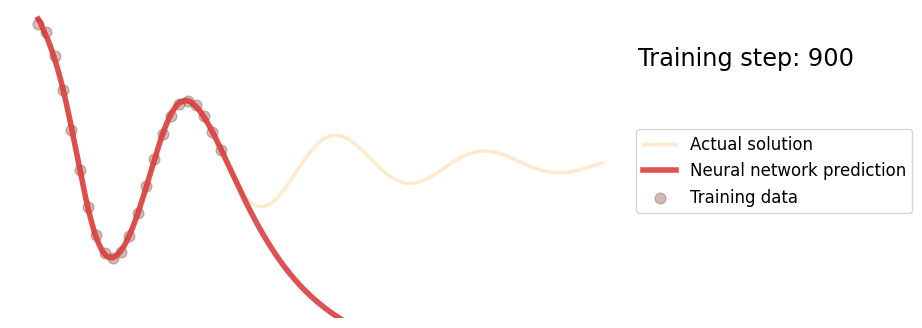

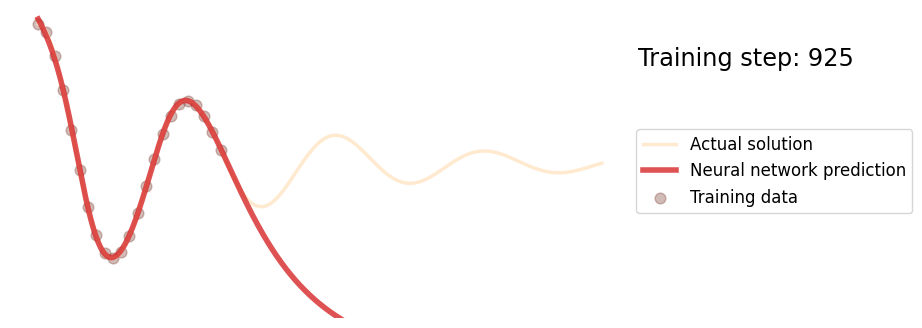

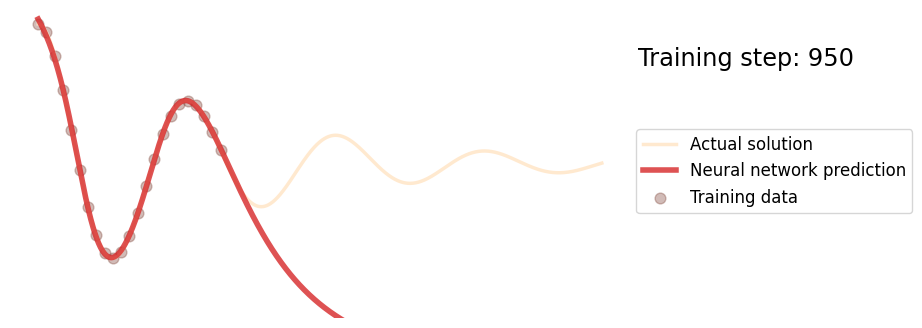

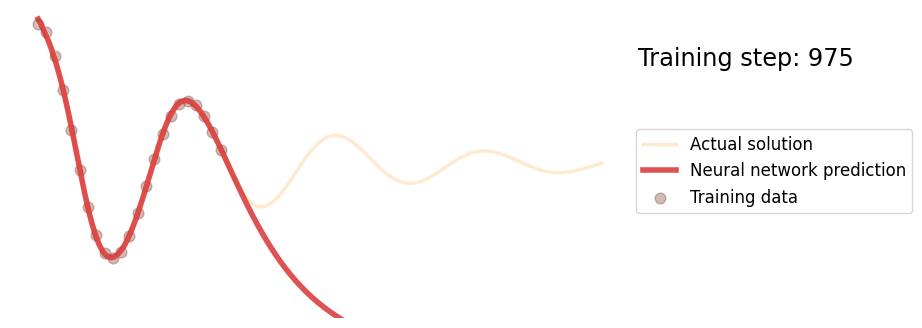

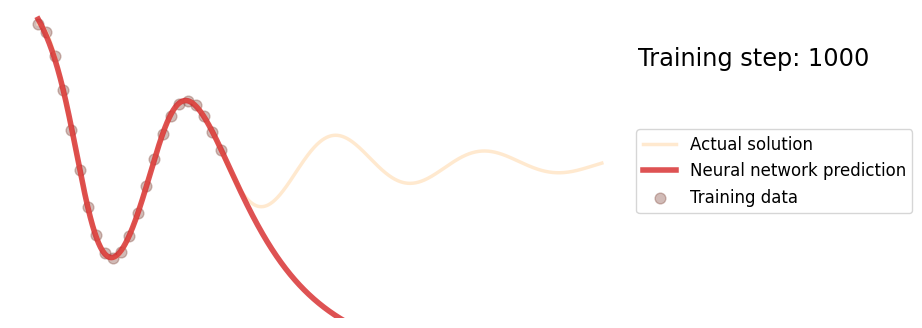

In [25]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    #x: Full domain points (1224 points from 0 to 1)
    #y: Exact analytical solution values
    #x_data: Training data points (300 with intervals of 18 in my case)
    #y_data: Training data values
    #yh: Neural network predictions
    #xp: None because it is Optional physics loss training locations which will be used in case 2


#Creating 2 curves on a plot representing the exact solutions , what the neural network predicted and what the training data was .
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="bisque", linewidth=2.5, alpha=0.8, label="Actual solution")
    plt.plot(x,yh, color="tab:red", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:brown", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=True, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")


# train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(1,1,32,3)

"""The parameters in FCN are respective :-
1.Number of input variable ( in our case time so 1 ) 2. Number of output variable (in our case position of object at that position x(t) so again 1 ) 3. Number of neurons in each hidden layer ; here 32 which is proven to be enough for 1 ODE 4.Number of layers other than input and output ( in our case 3 which is agiain enough for 1st degree ODE )"""

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
for i in range(1000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()


    # plot the result as training progresses
    if (i+1) % 25 == 0:
        yh = model(x).detach()
        plot_result(x,y,x_data,y_data,yh)

<h4 color="bisque"> As you can see when you press enter on the previous code , it demonstrates beautifully how the neural networks trains itself . The images are at the interval steps of 25. However we also see that while the function takes shape at step 400, it stagnates thereafter . This demonstrates that neural networks alone alone are not feasible for working on physics-heavy problems . </h4>

<h1 color="bisque"> NEURAL NETWORK BUT WITH PINNS </h1>
<h5 color="bisque"> Here comes the main part . We will now add the underlying differential function to the loss function .
The physics loss will make sure the solution is consistent with respect to the differential equation it relies upon . How this is achieved lies in the principle that we penalise the residual of the differential equation .

/tmp/ipython-input-25-621800333.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,4))


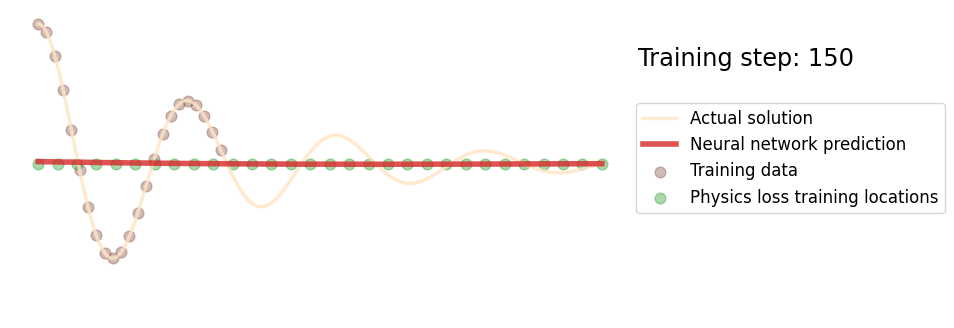

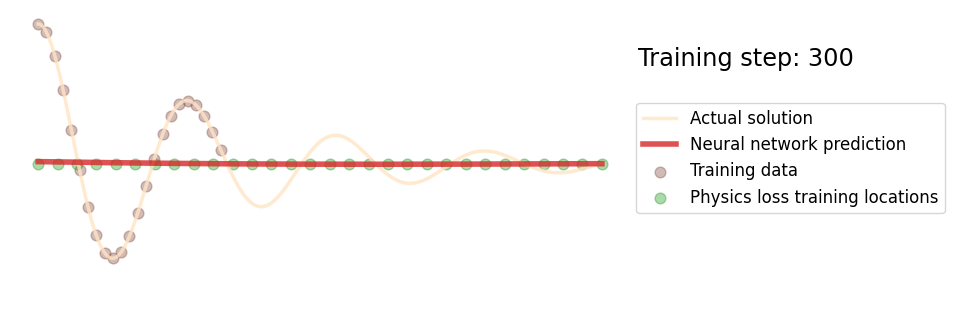

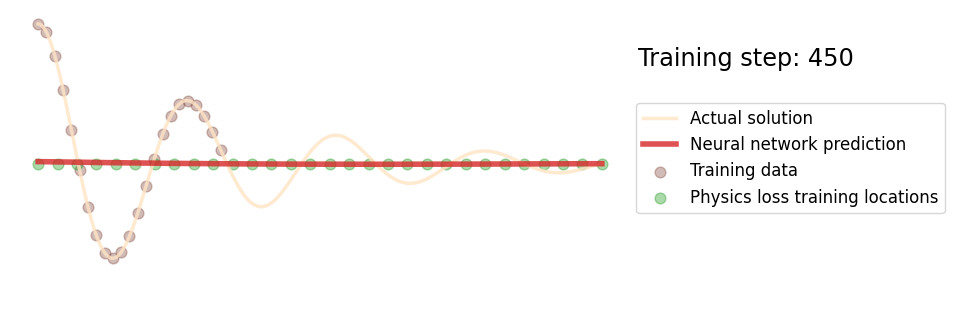

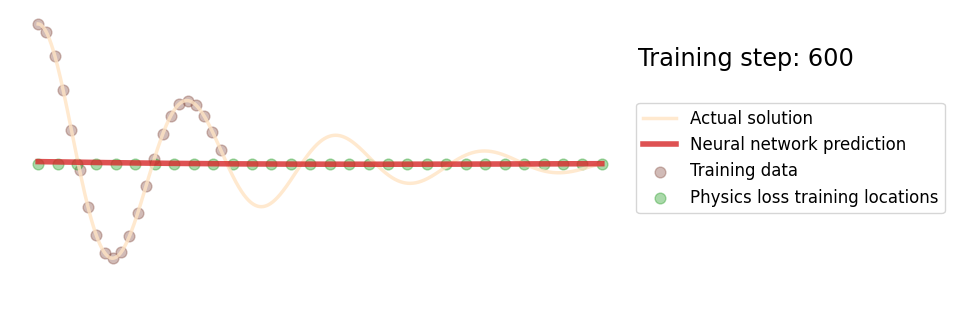

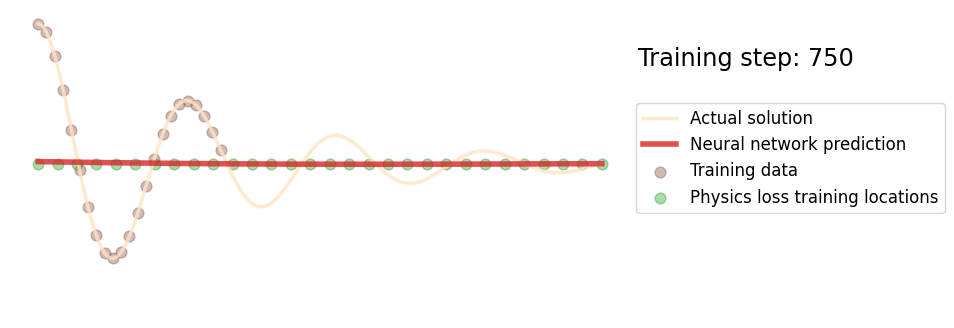

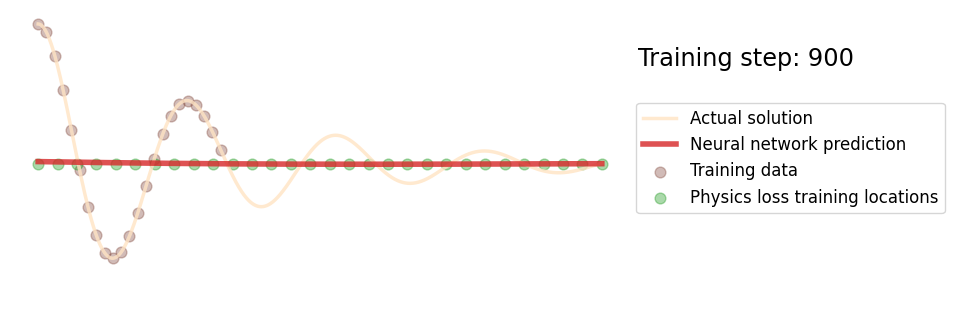

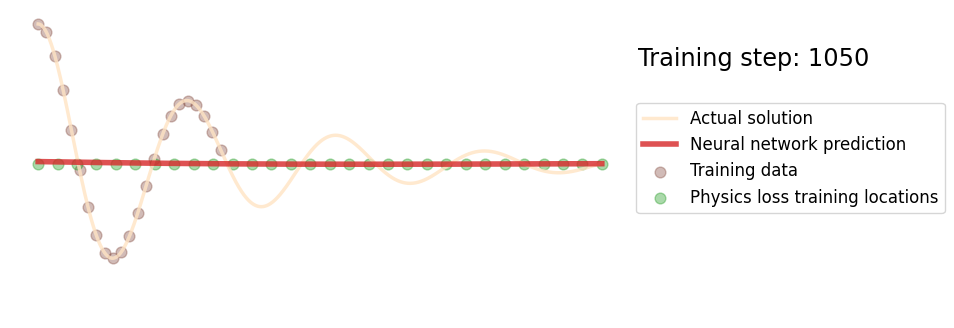

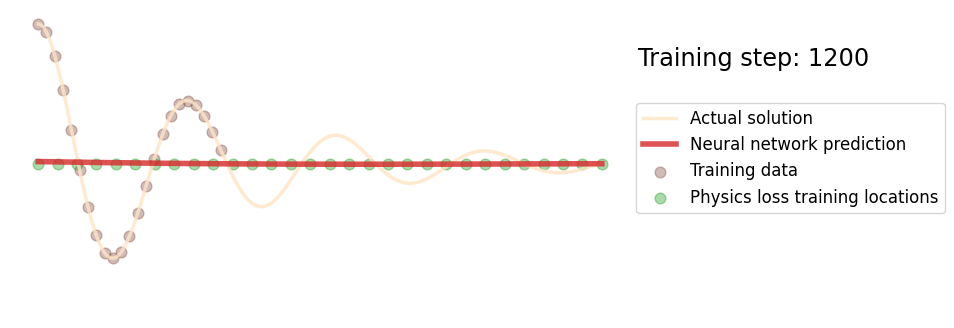

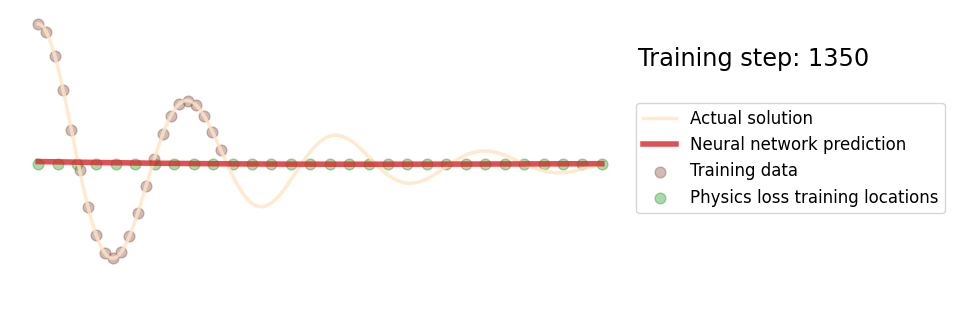

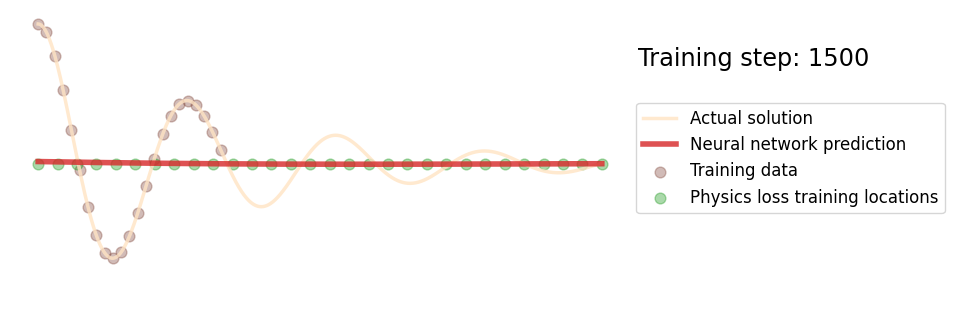

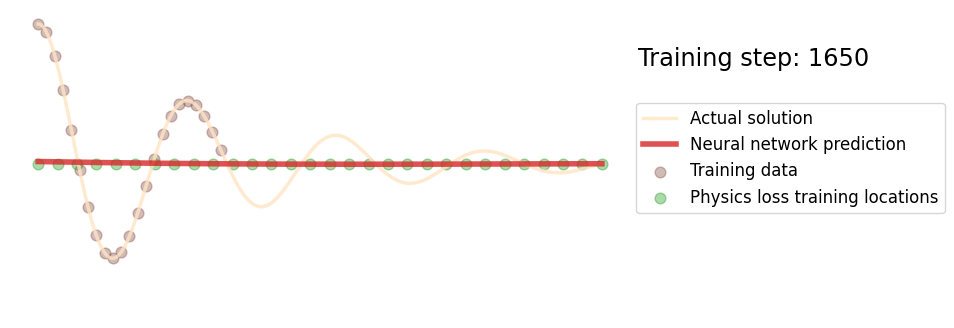

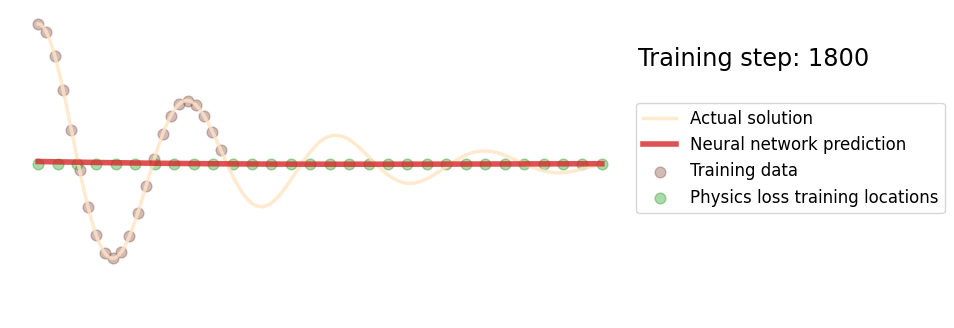

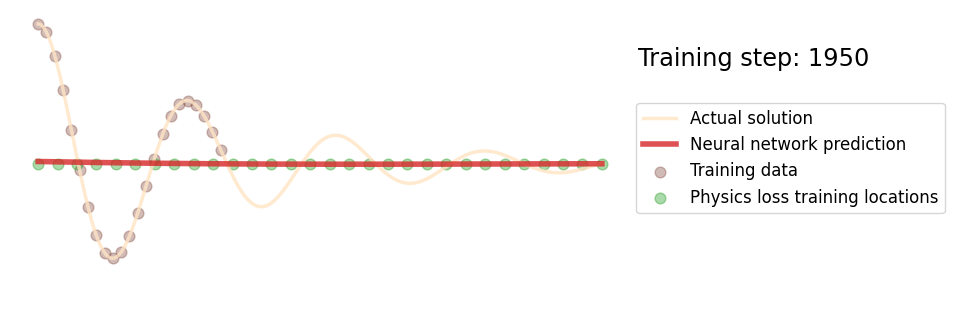

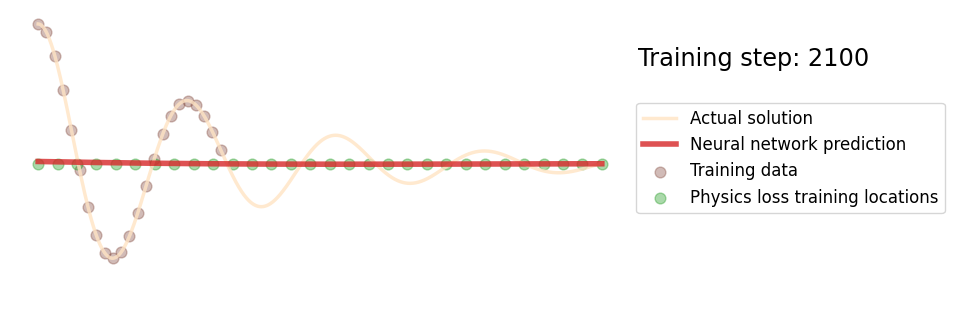

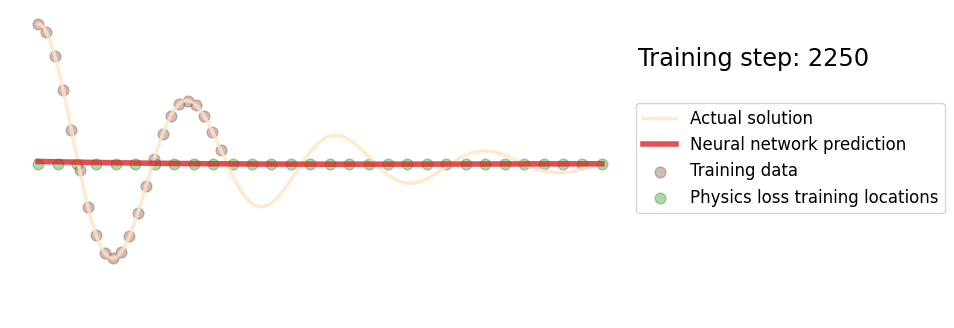

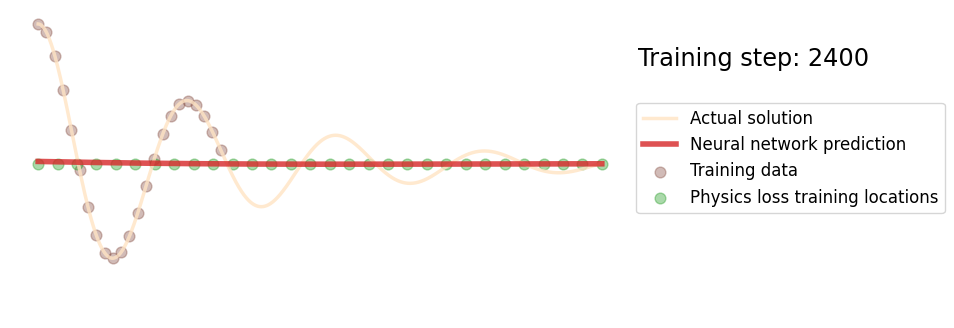

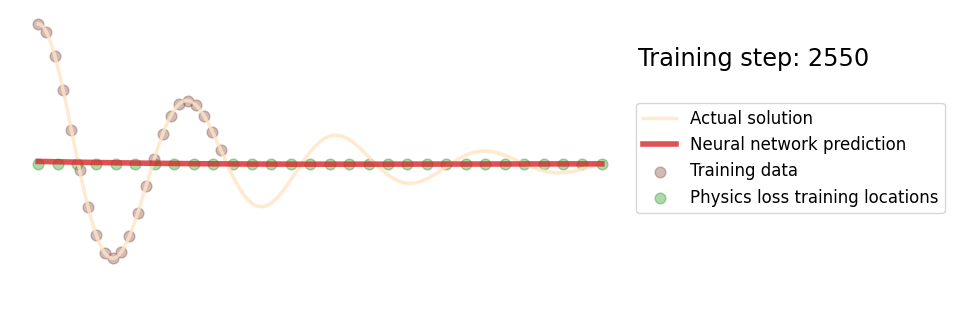

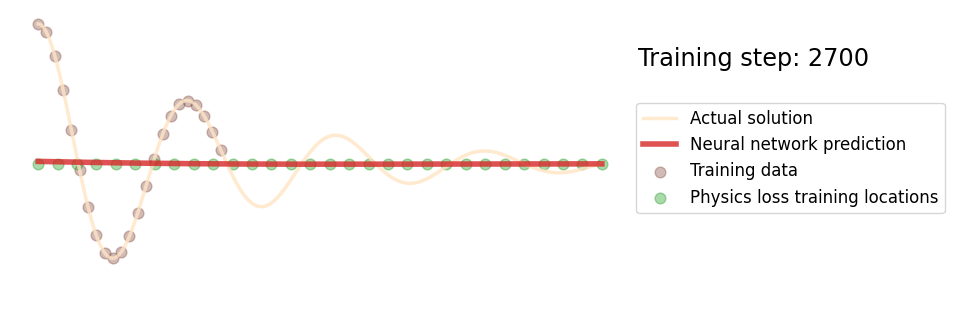

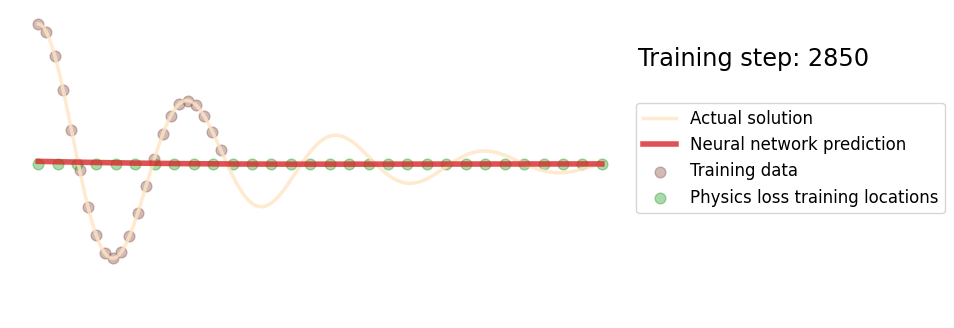

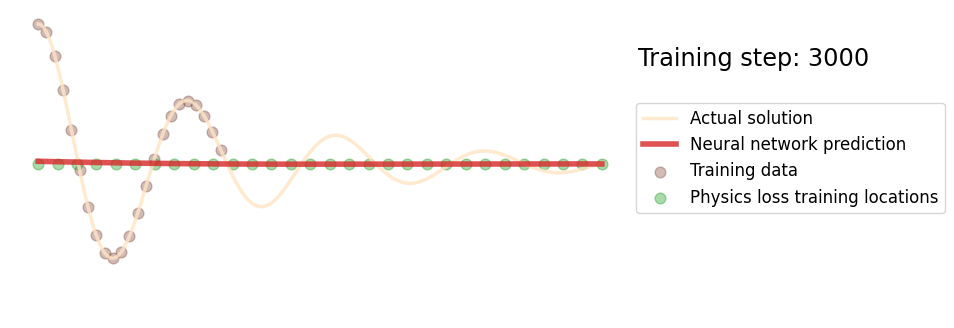

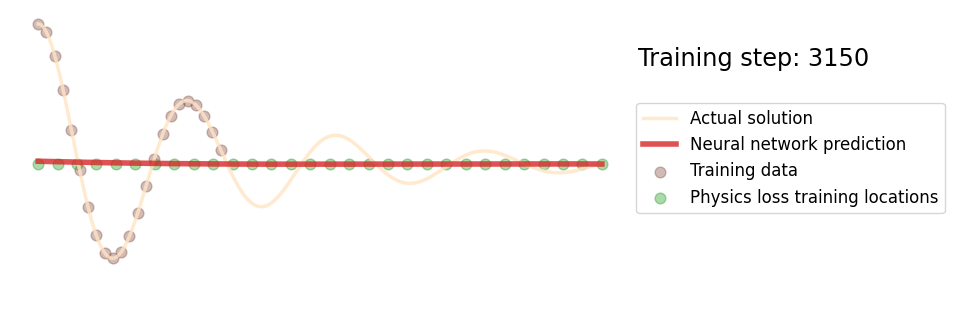

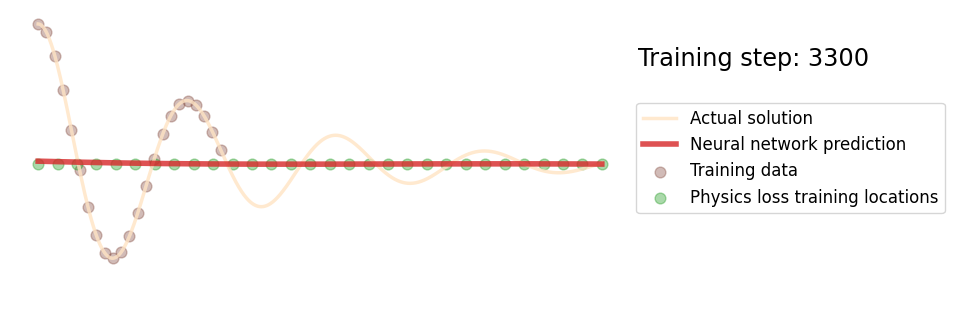

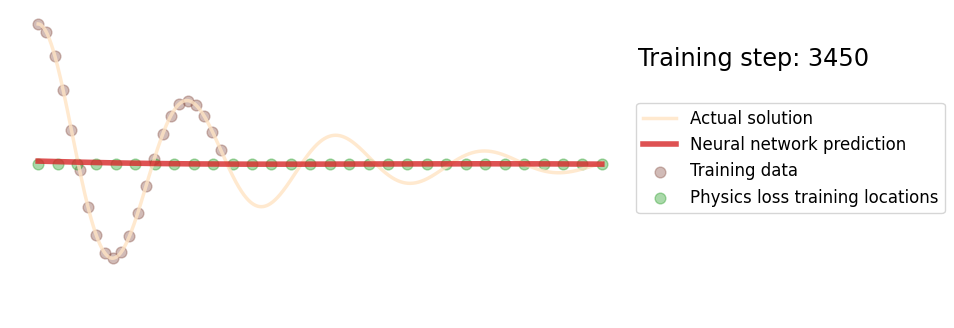

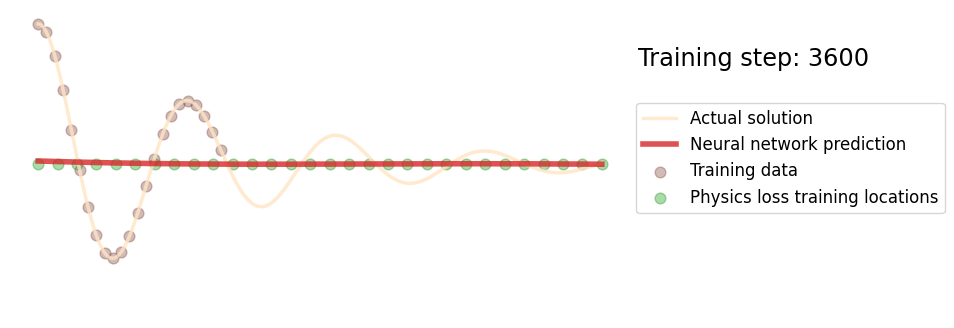

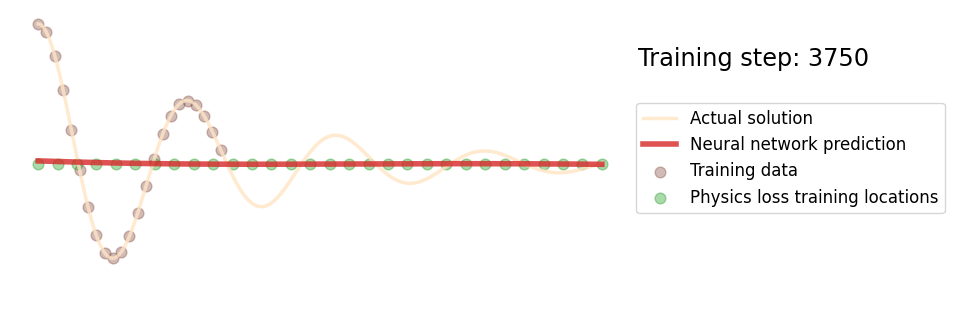

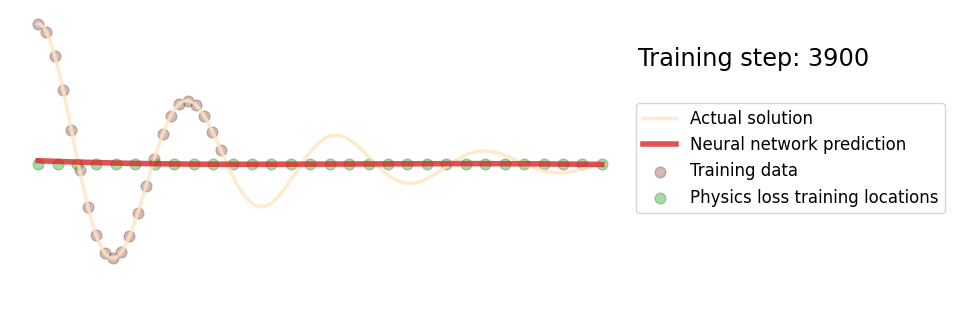

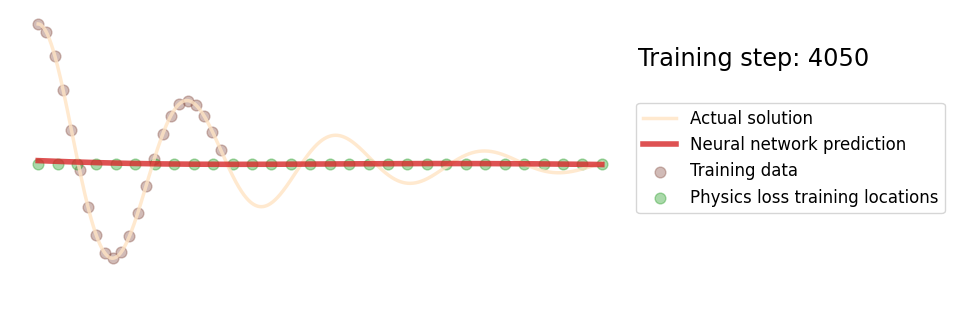

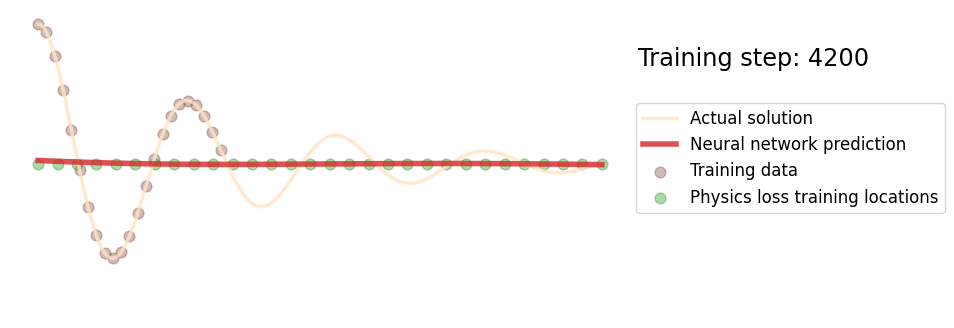

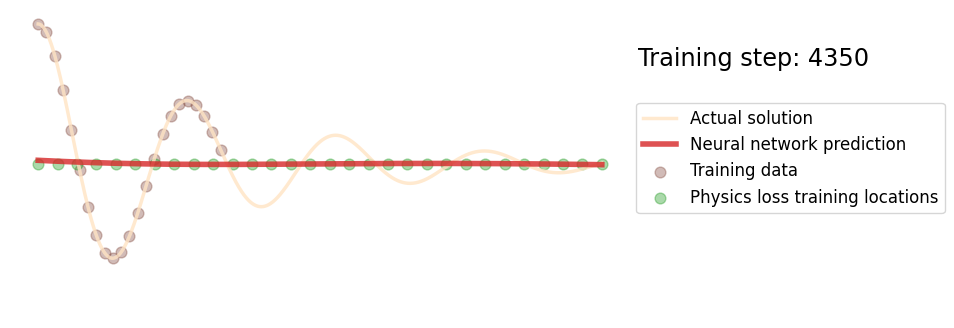

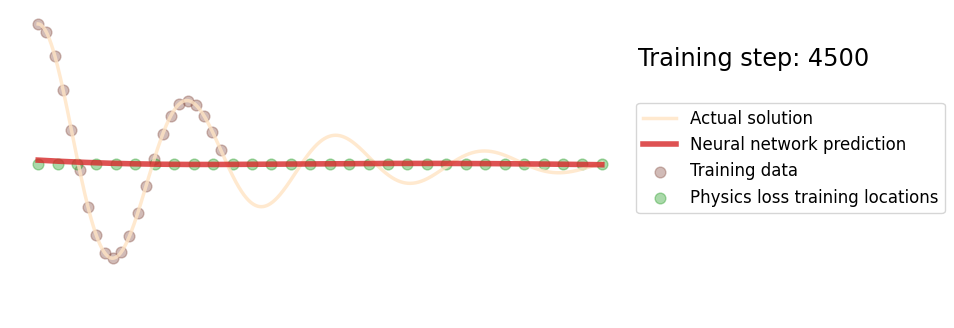

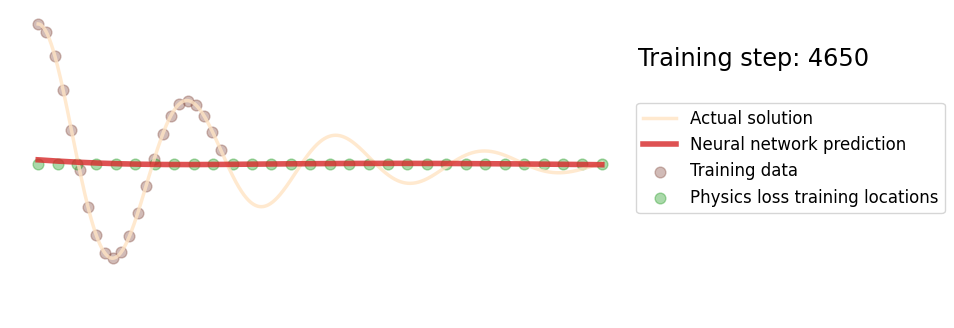

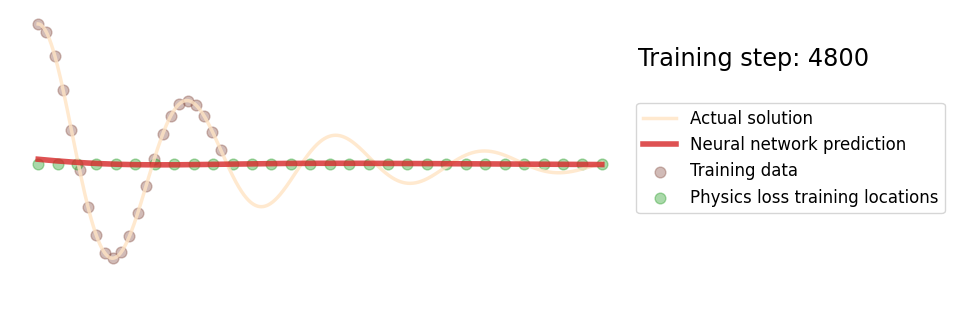

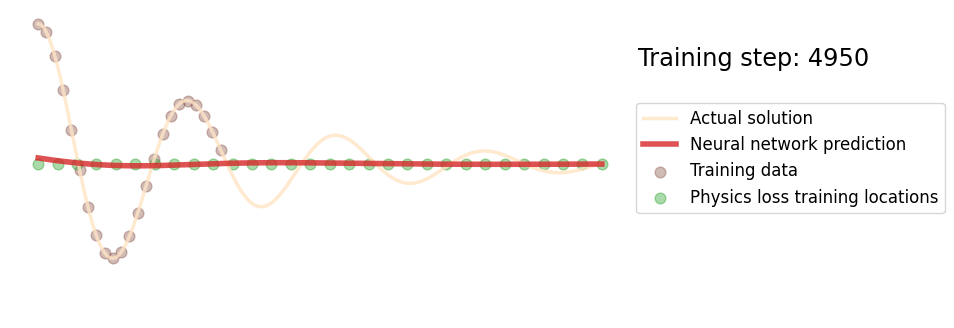

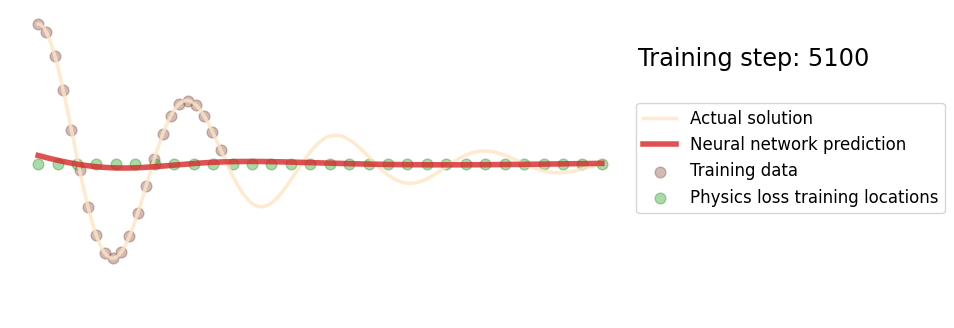

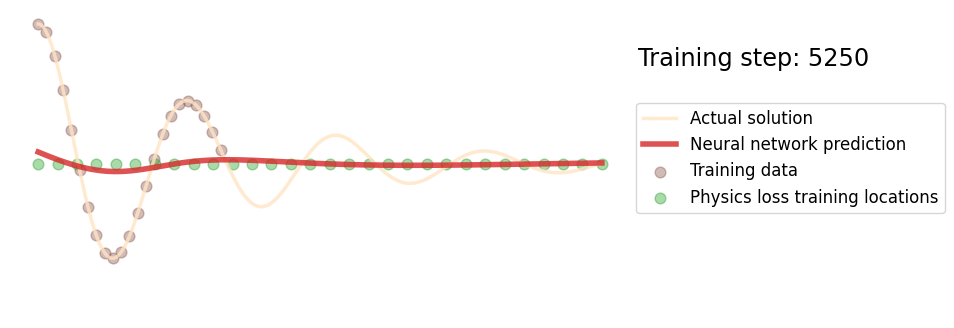

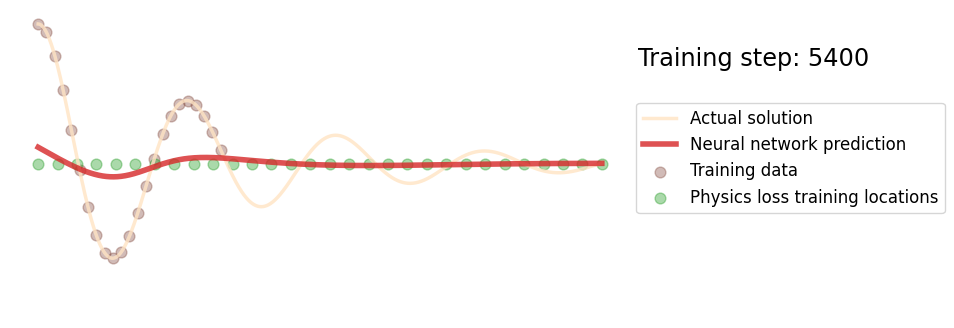

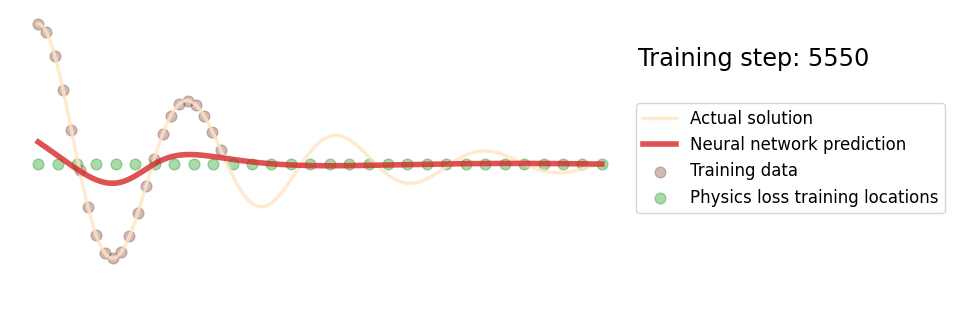

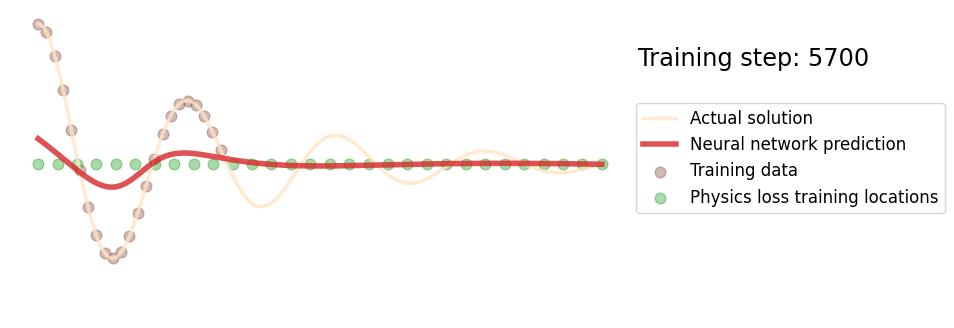

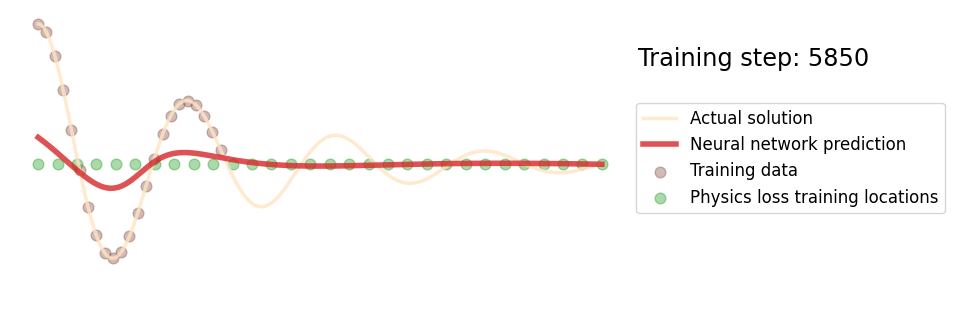

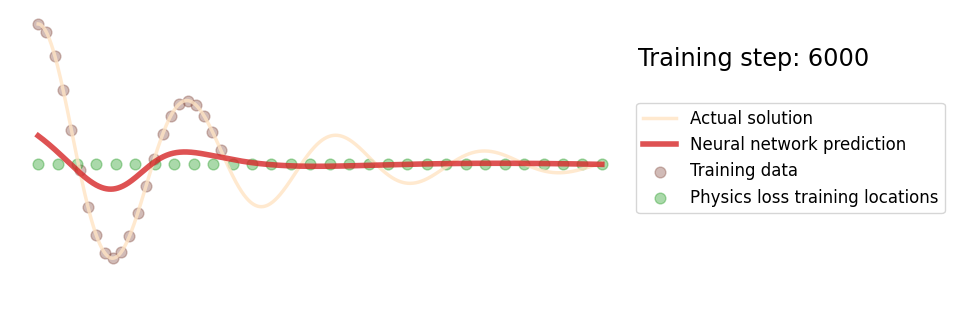

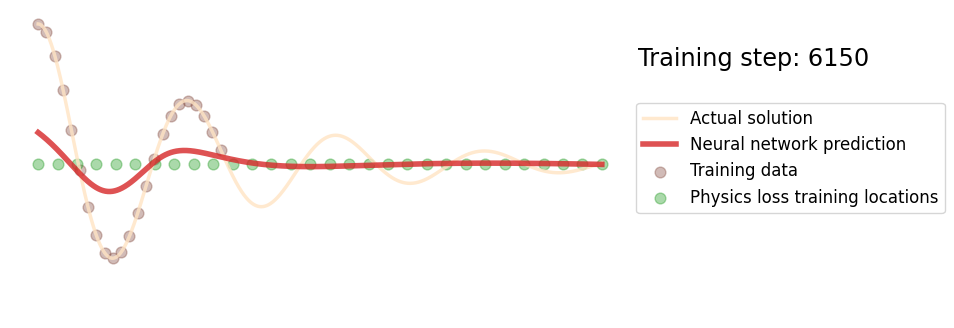

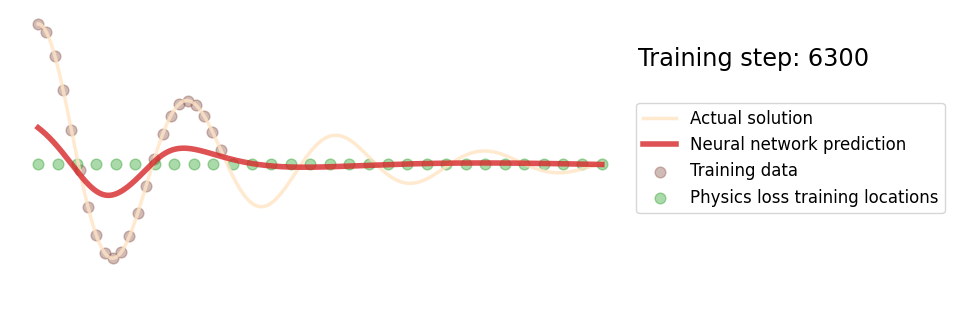

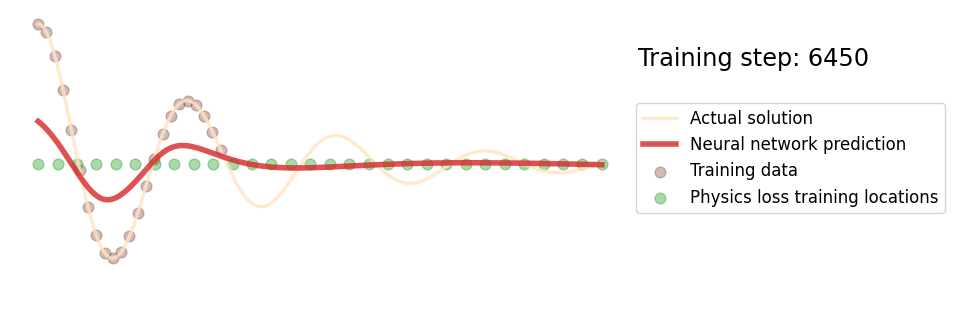

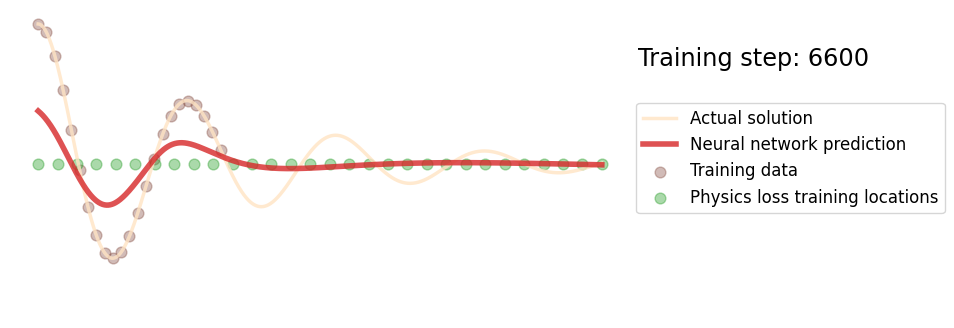

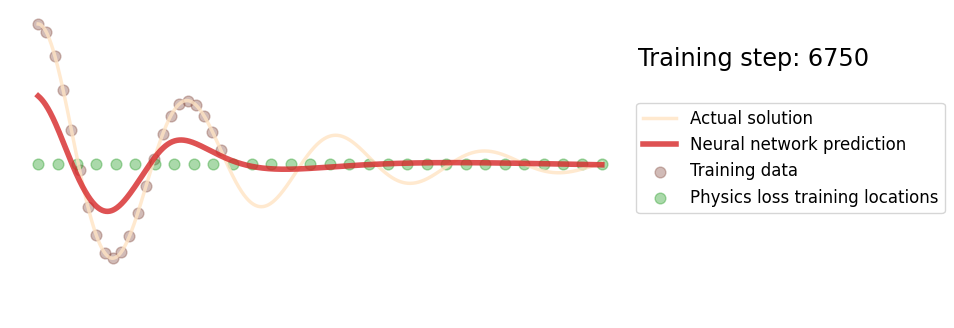

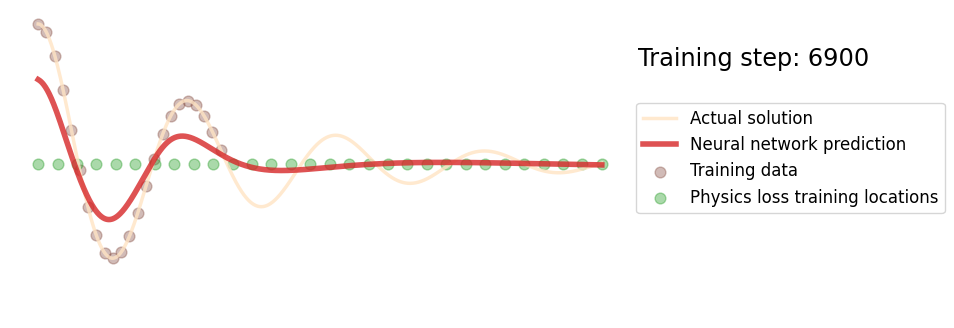

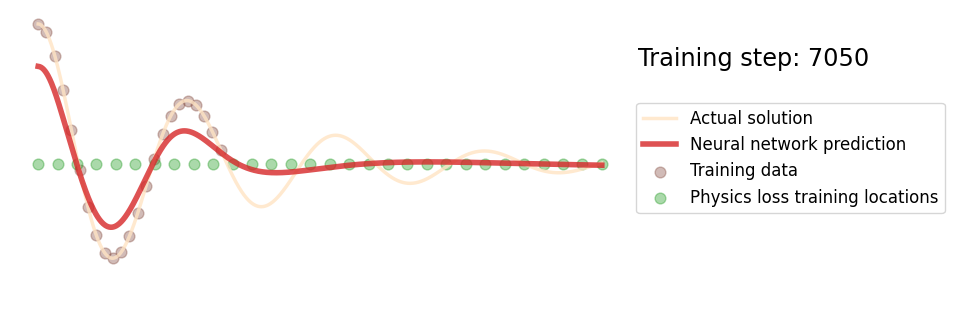

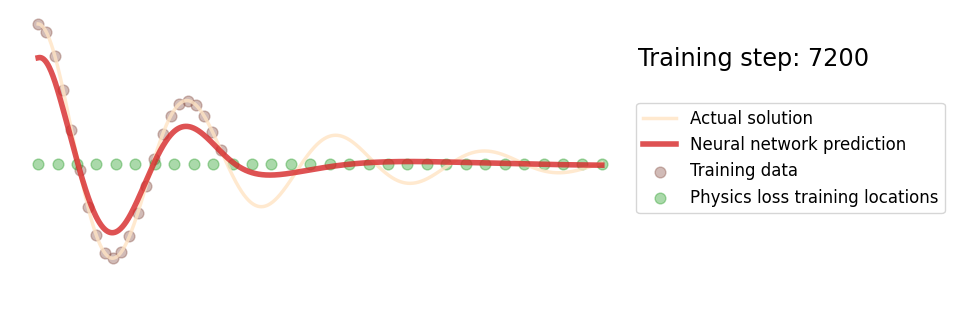

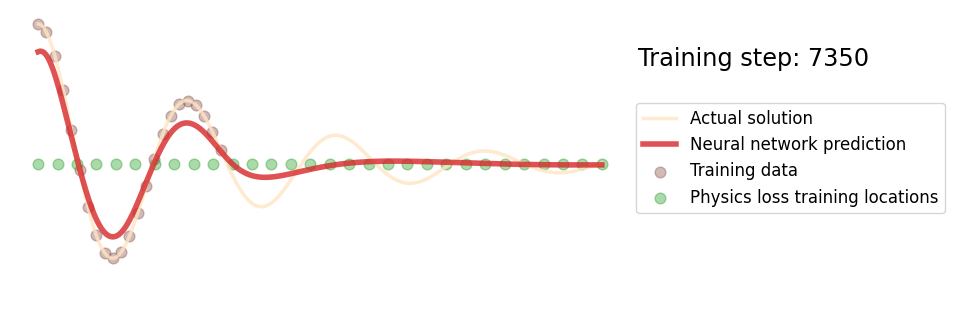

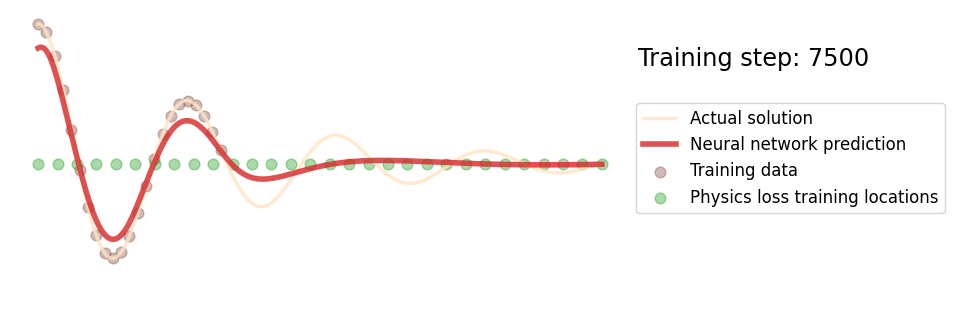

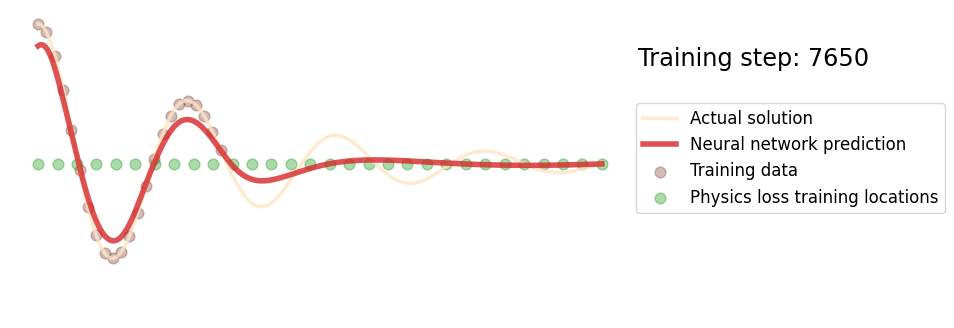

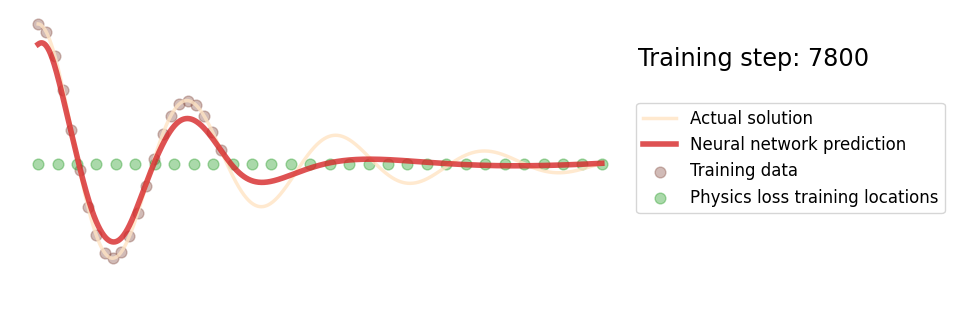

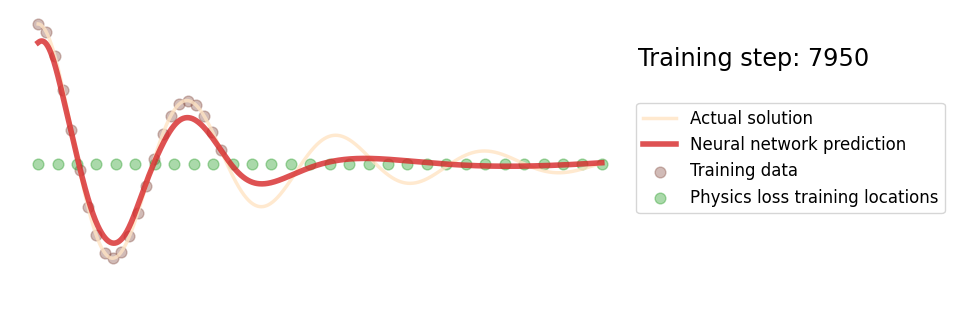

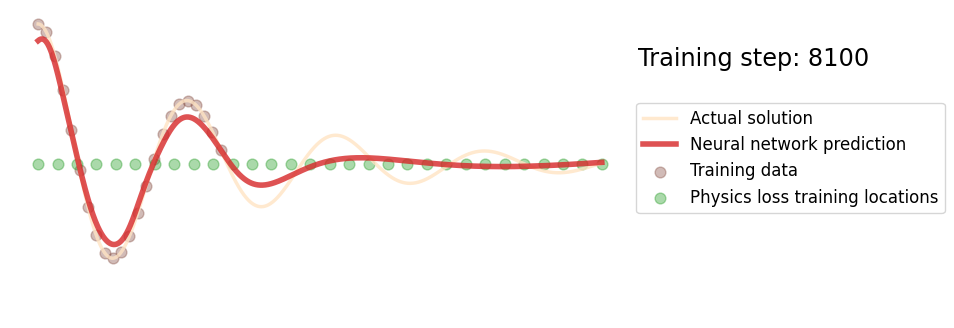

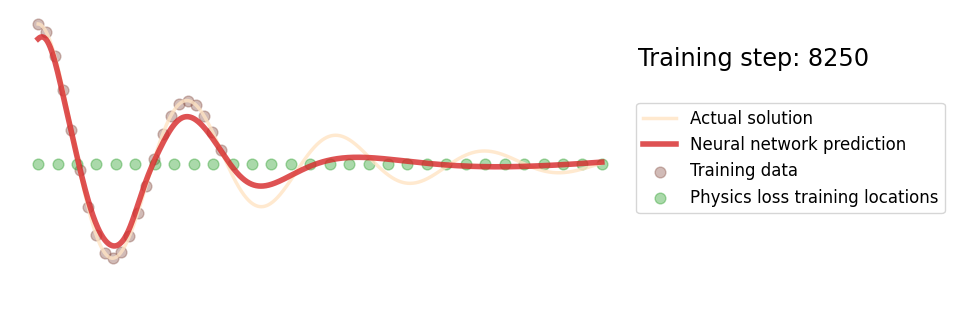

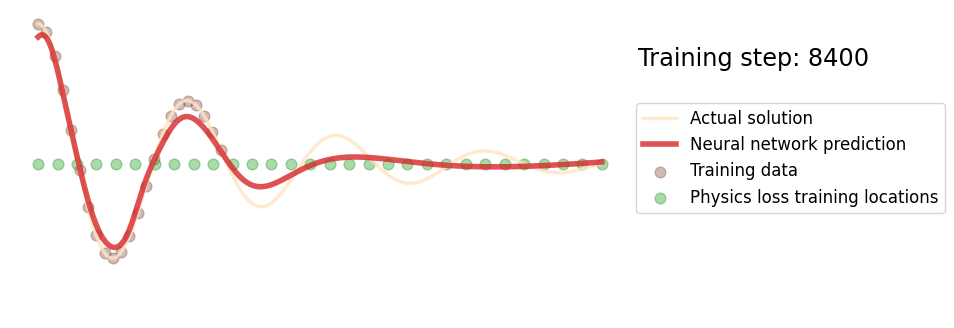

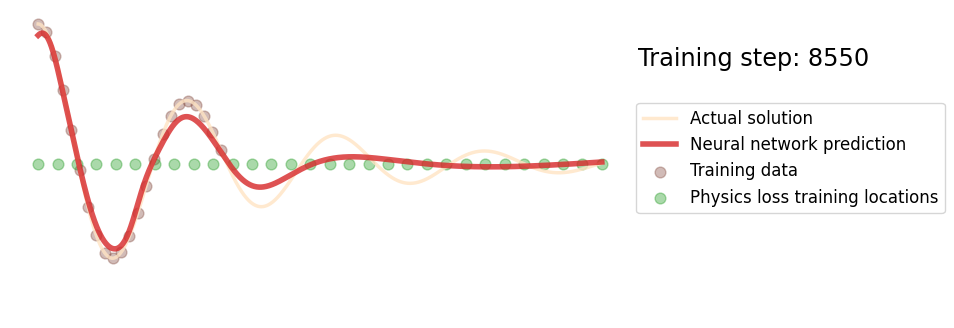

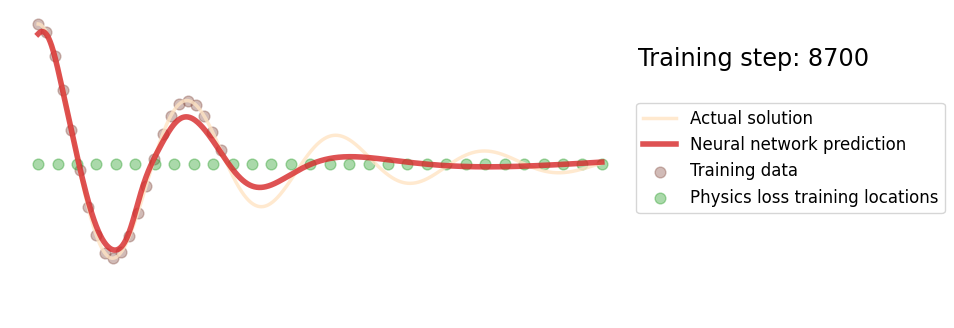

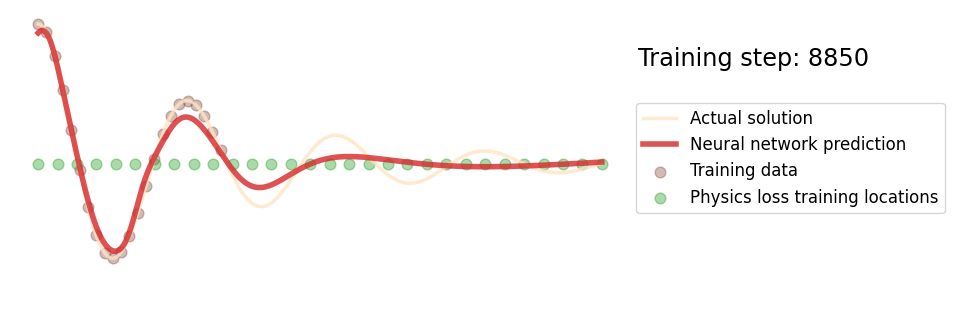

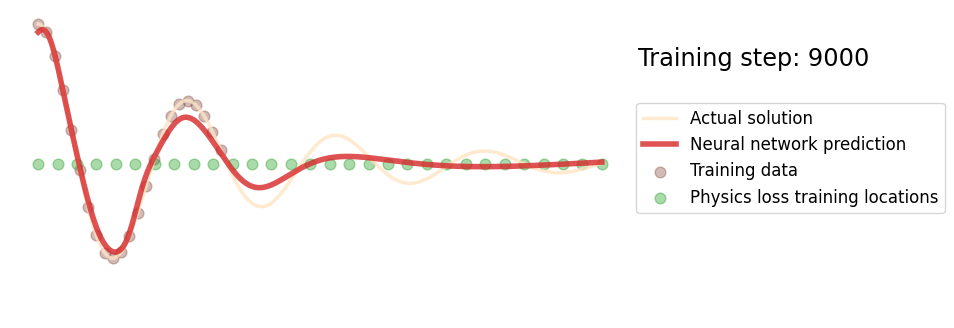

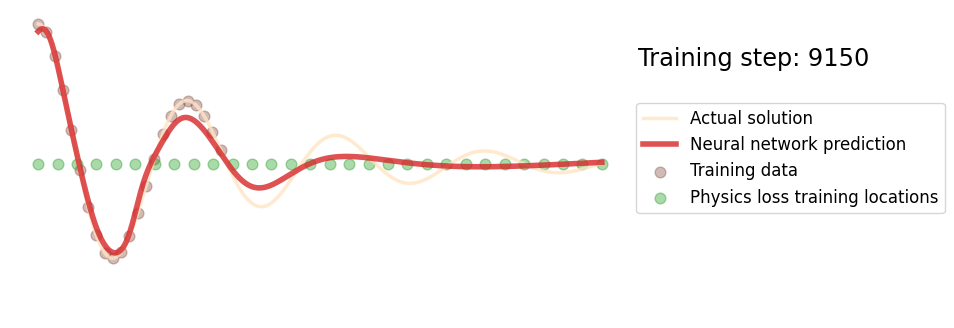

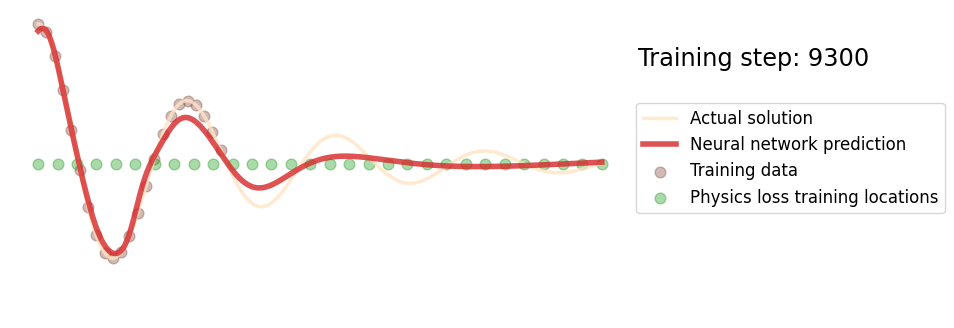

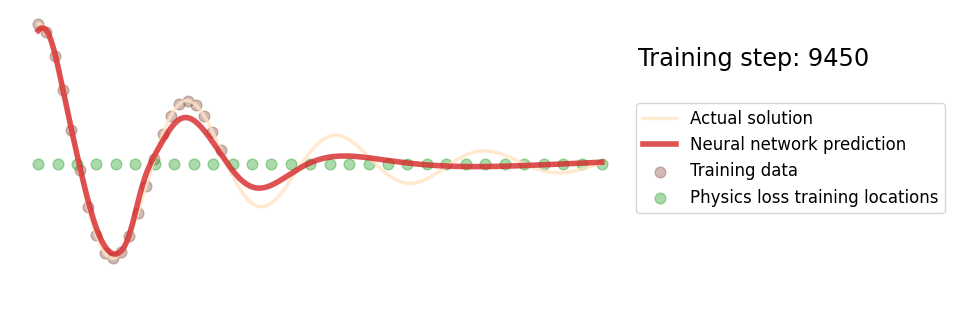

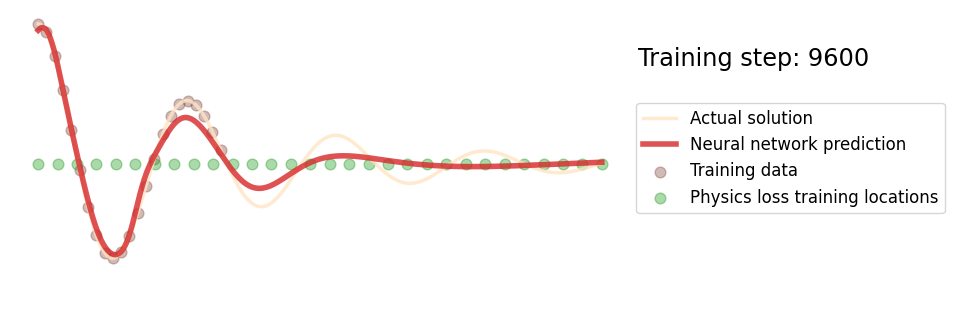

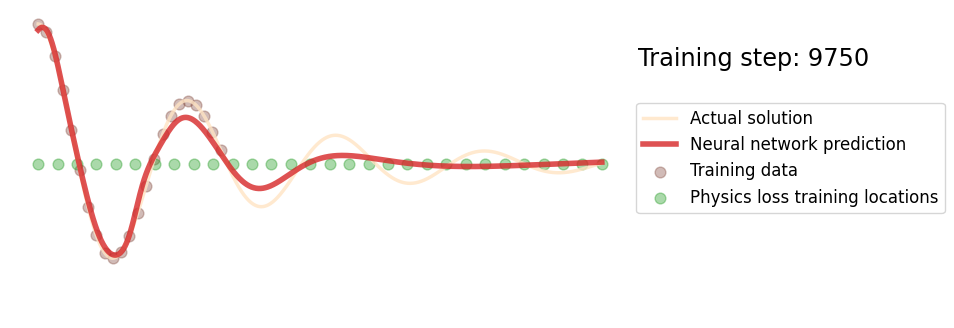

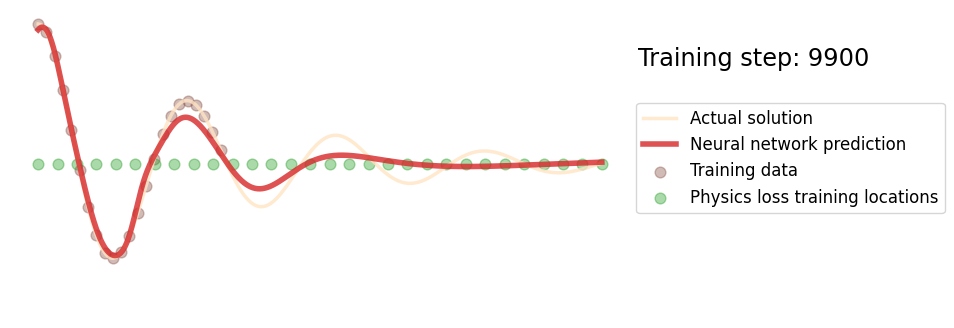

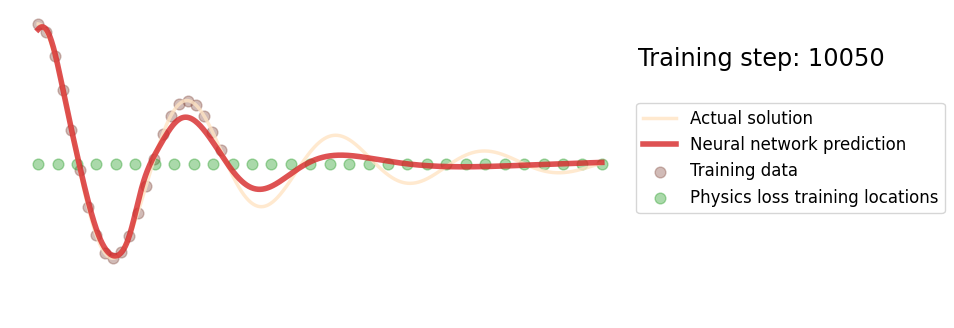

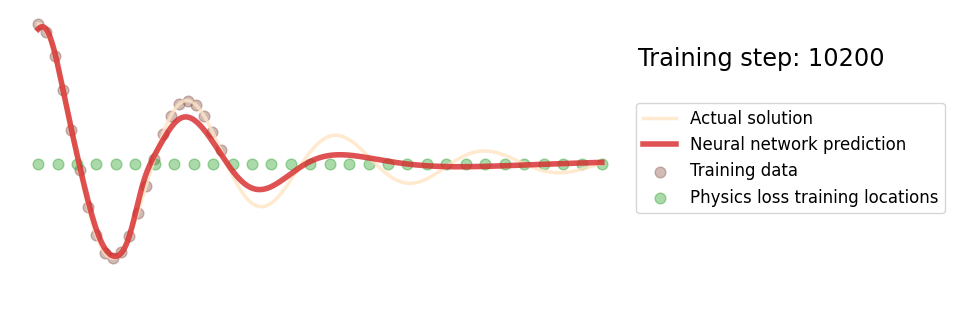

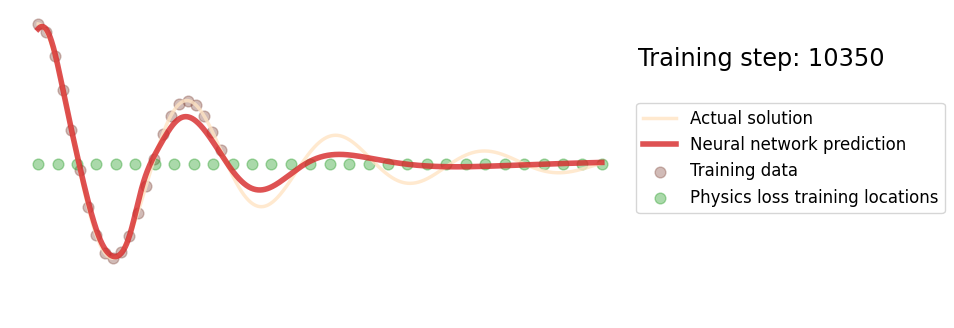

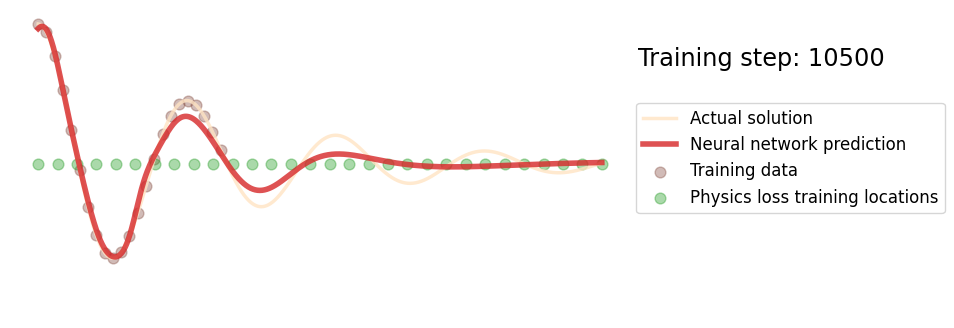

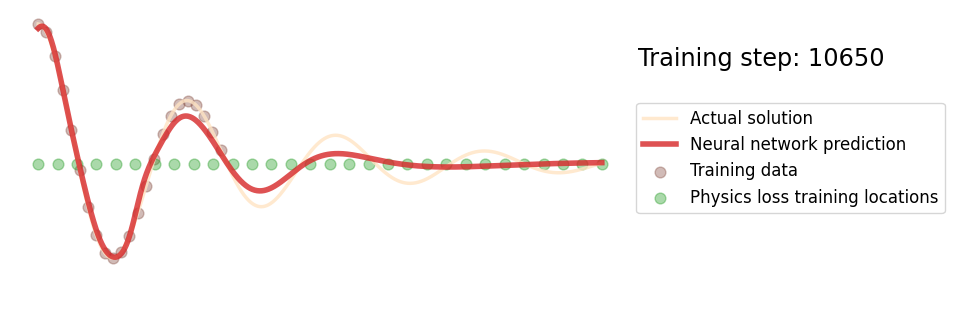

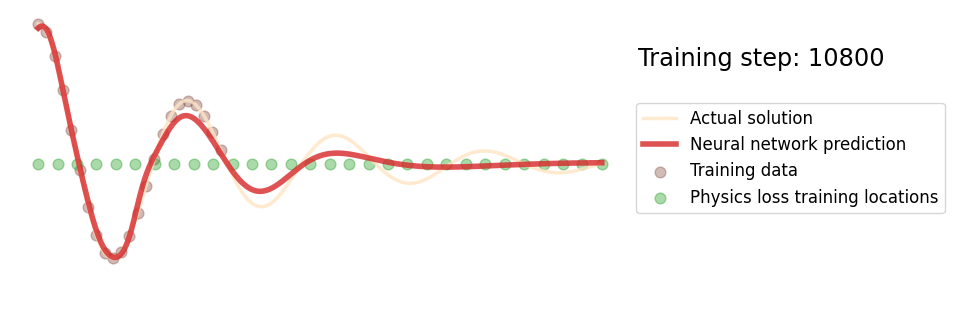

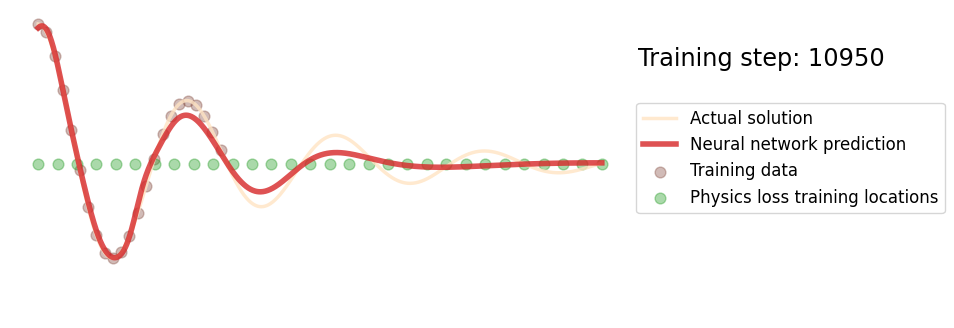

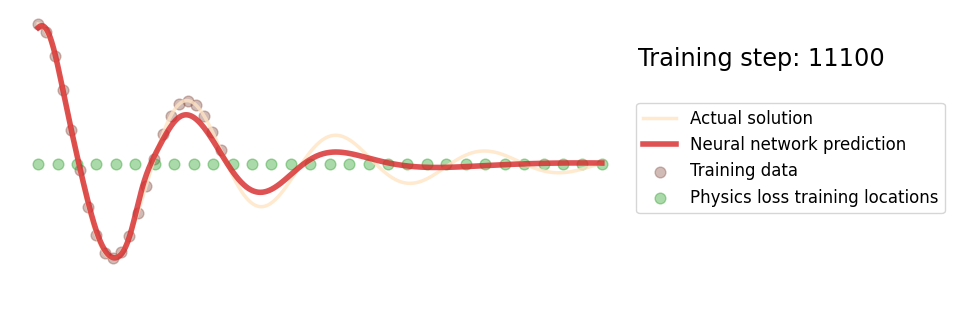

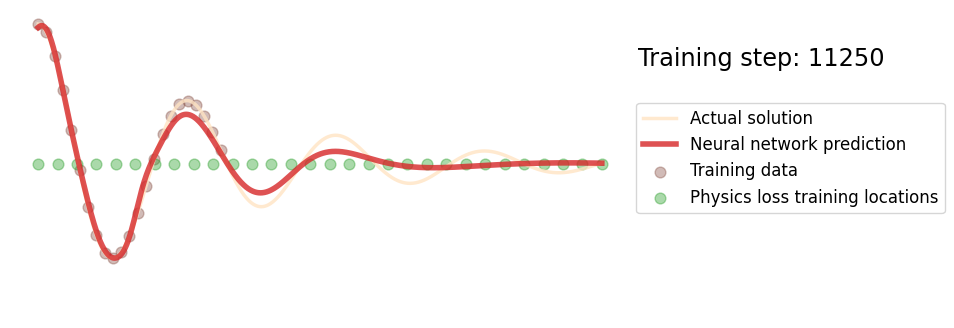

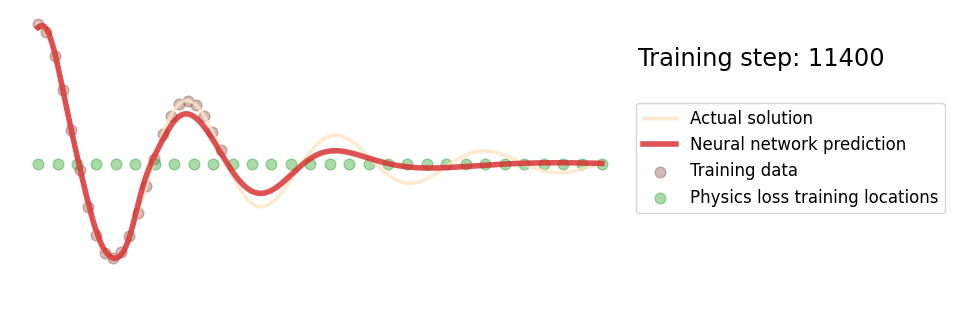

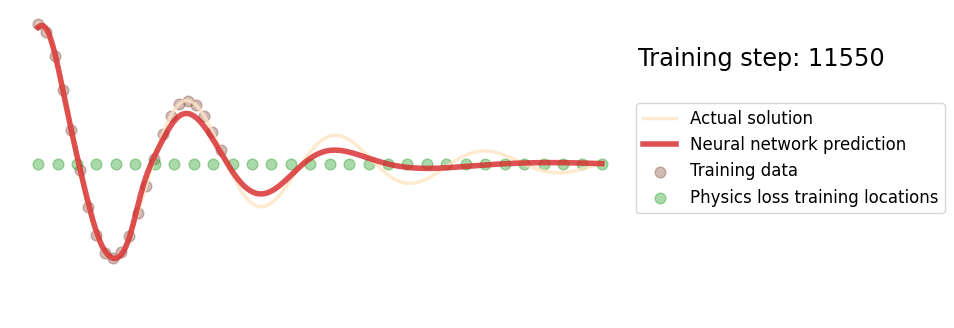

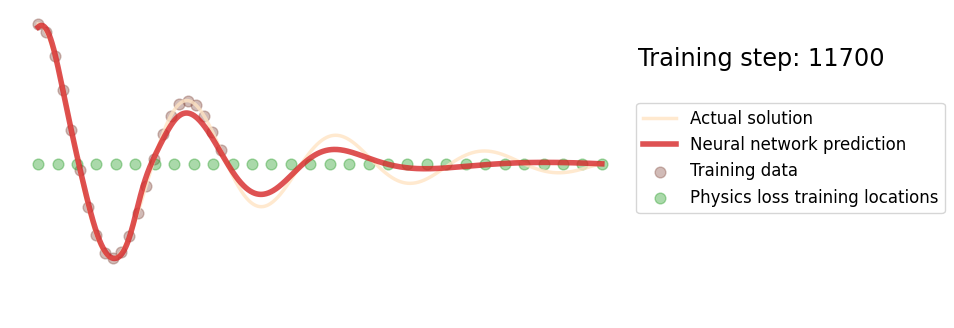

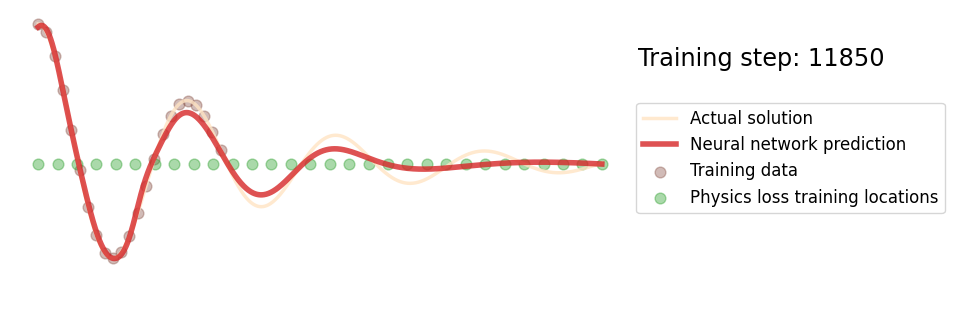

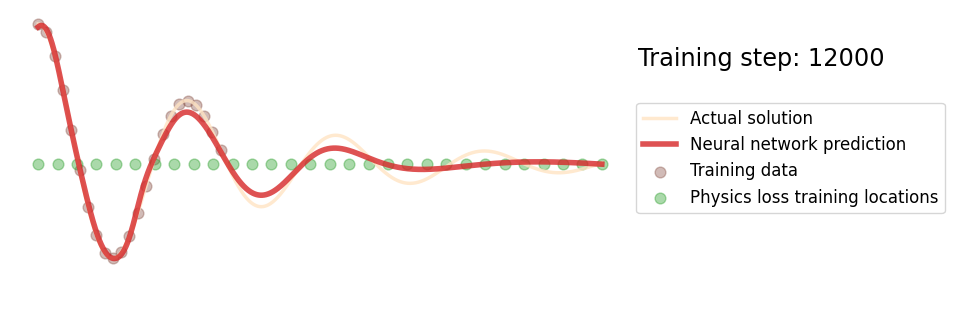

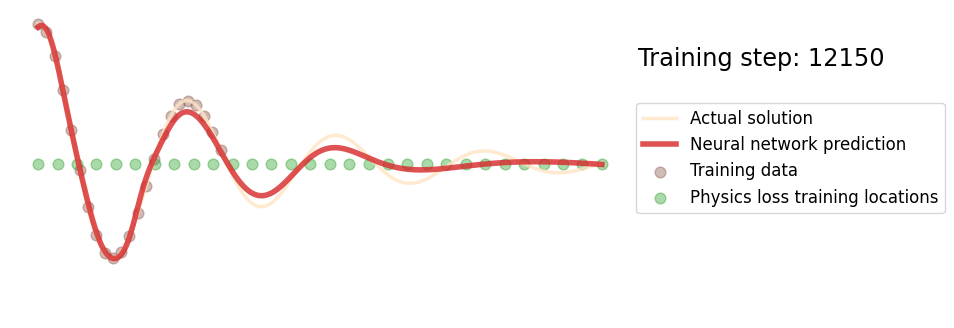

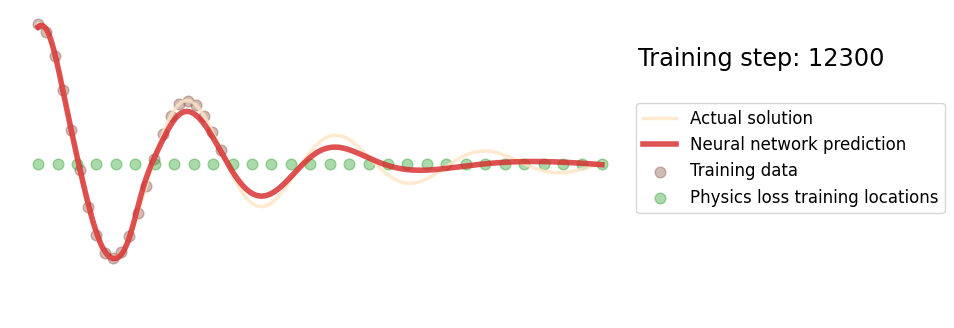

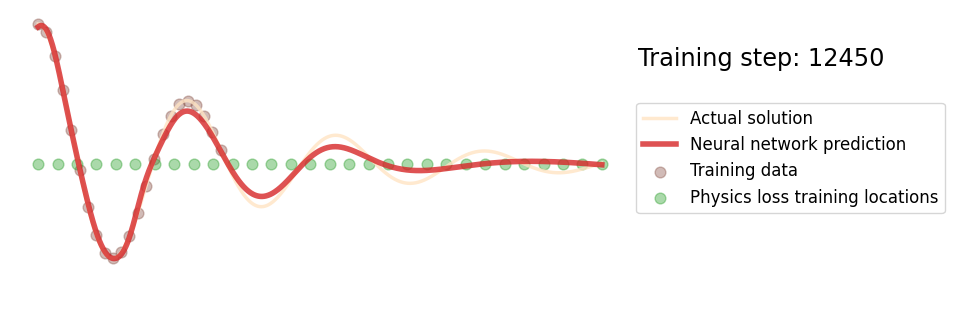

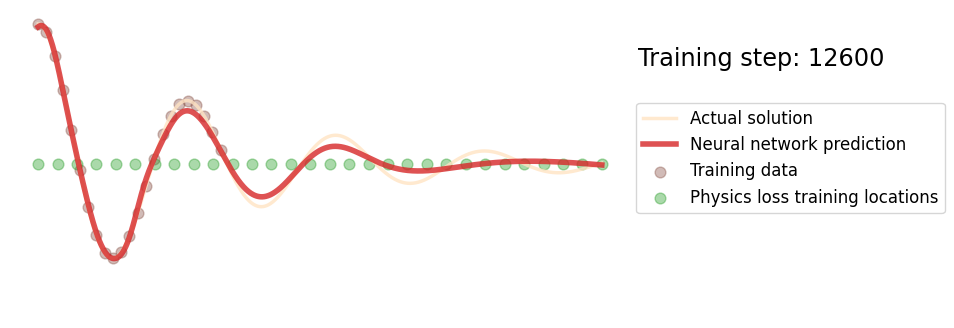

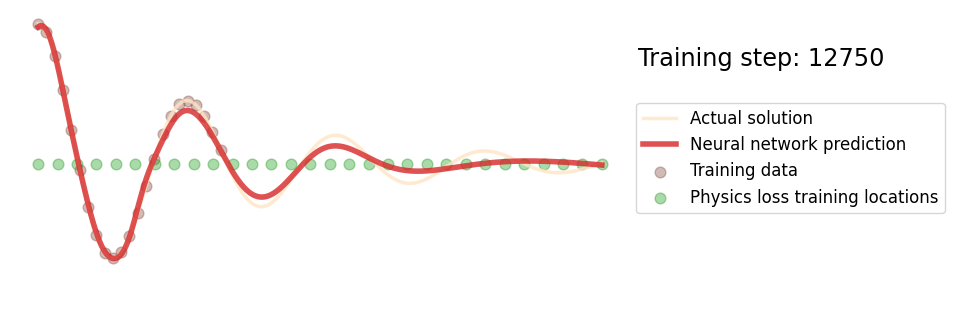

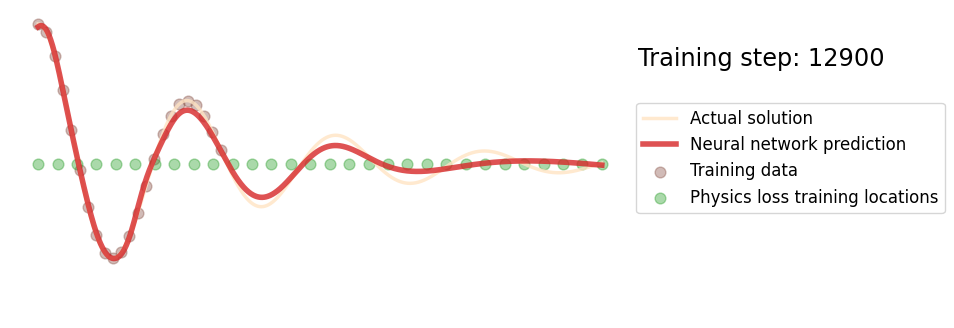

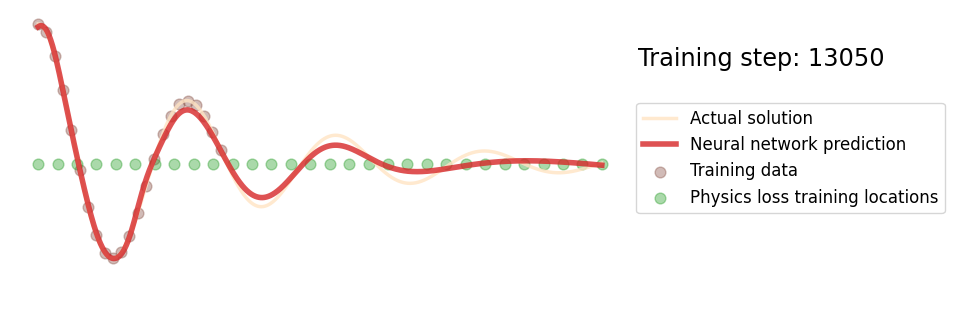

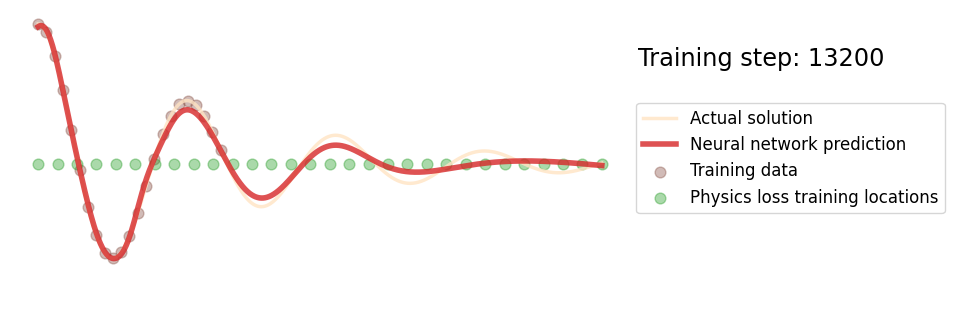

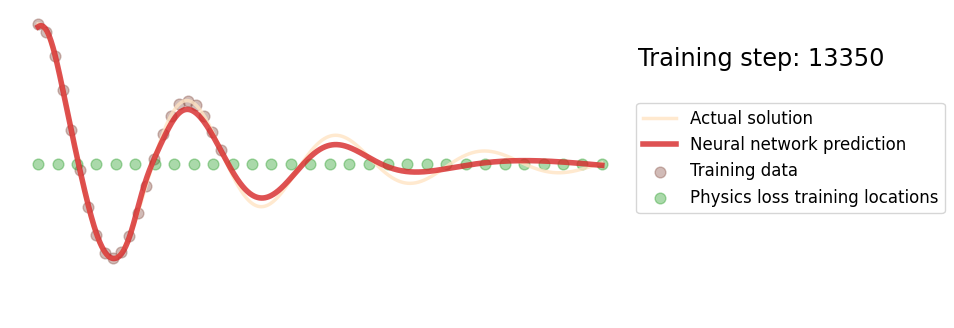

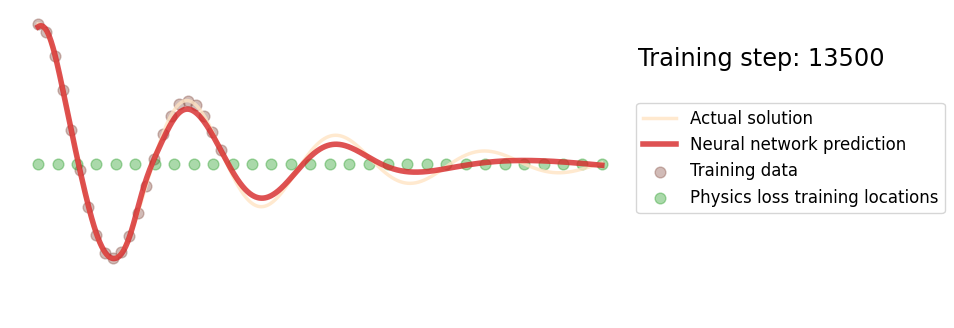

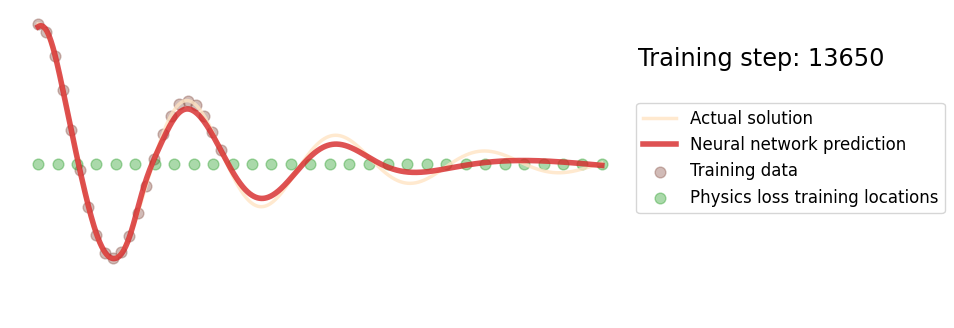

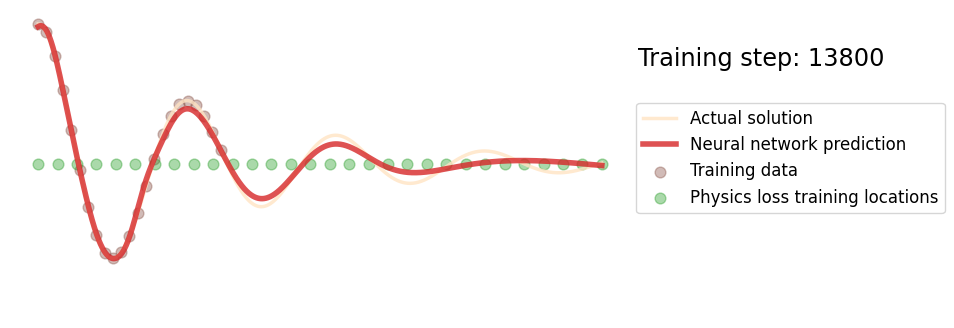

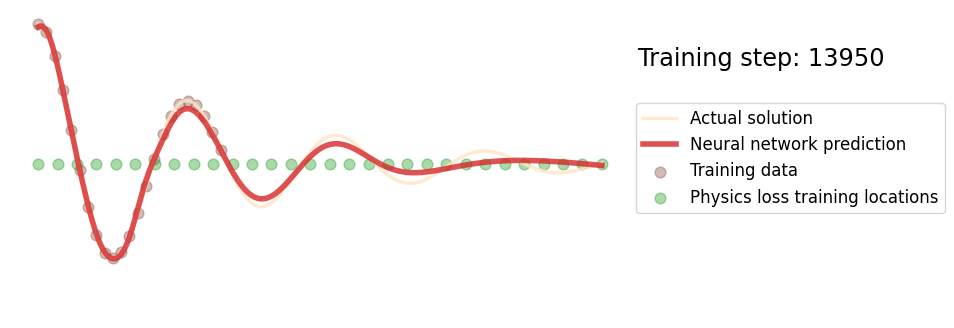

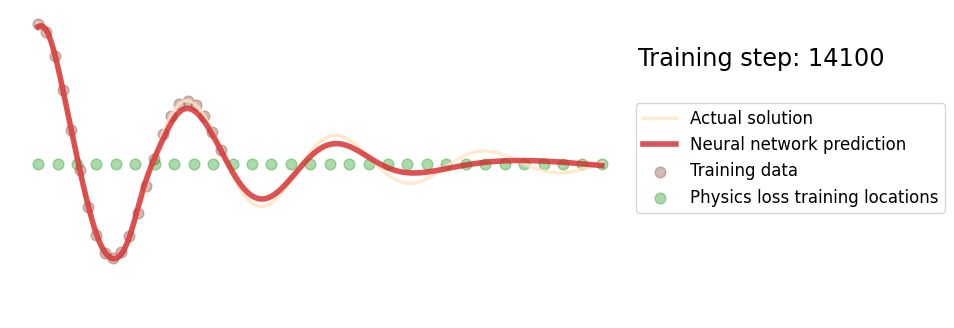

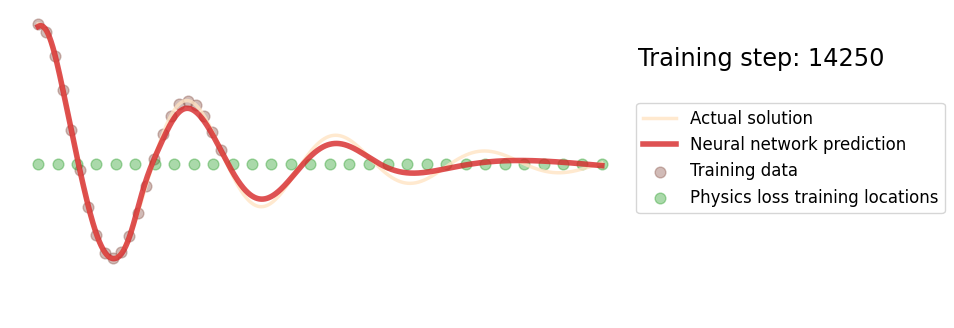

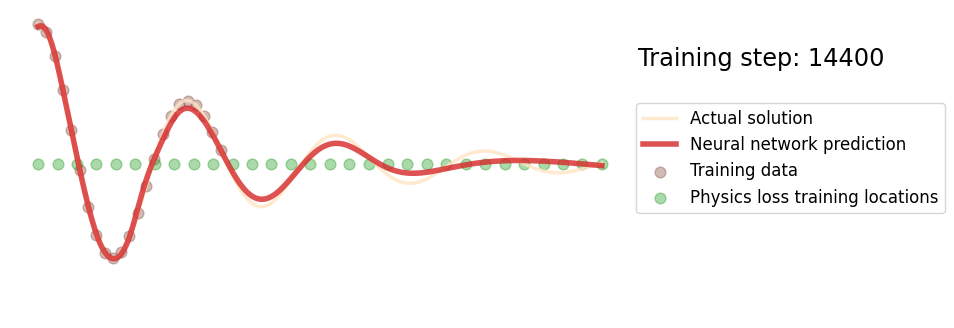

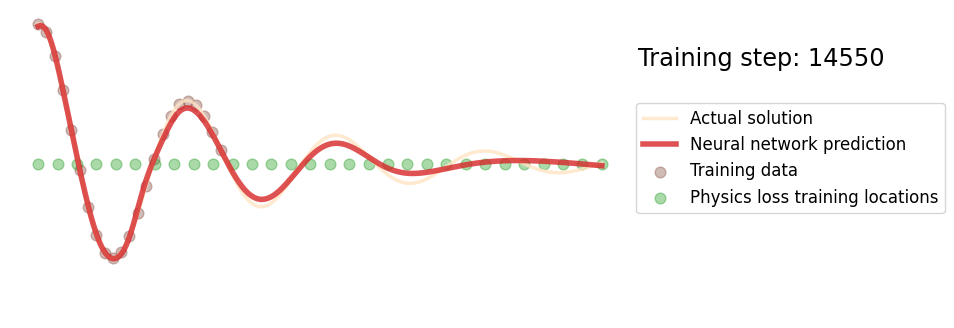

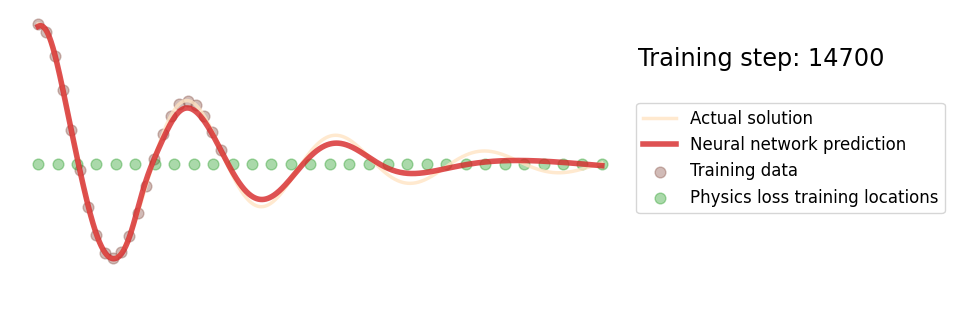

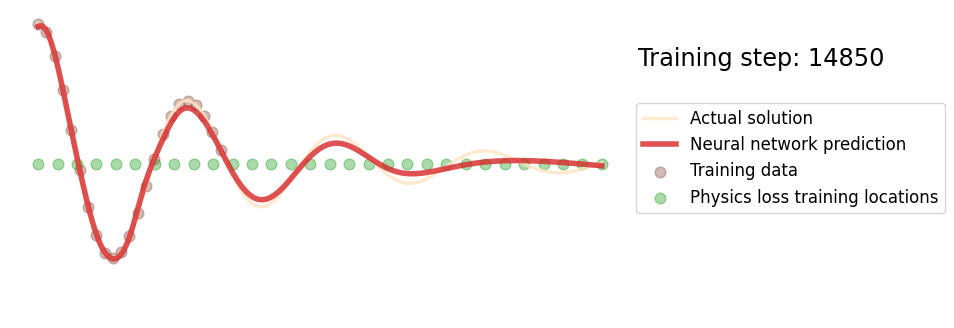

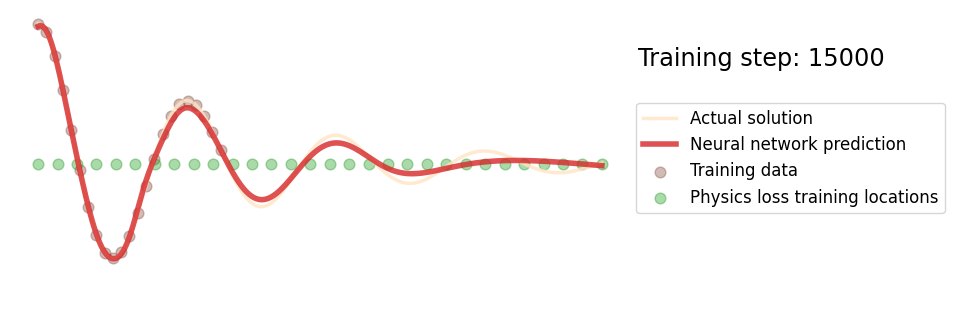

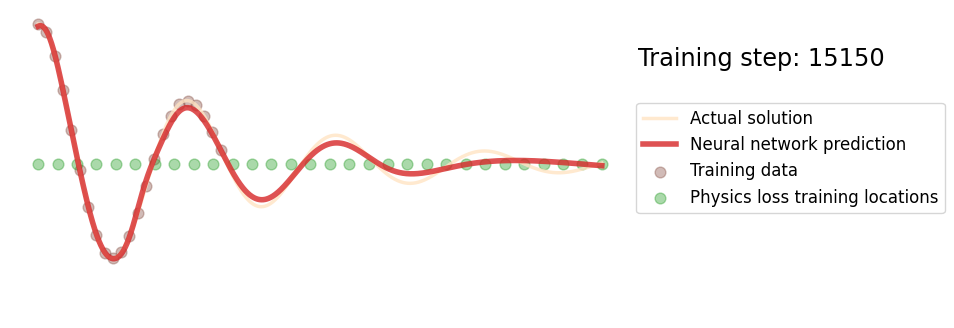

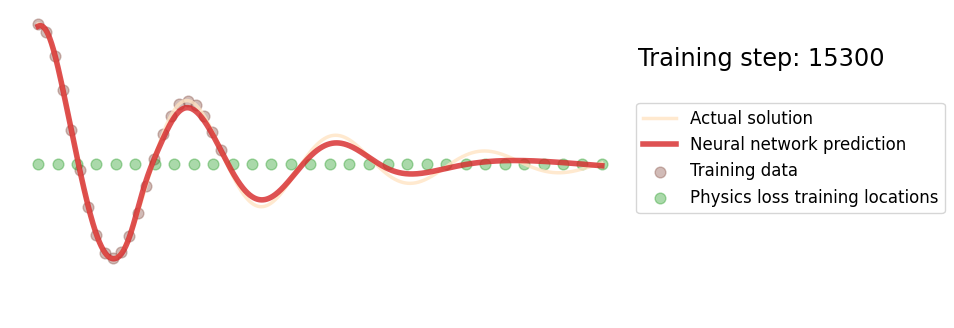

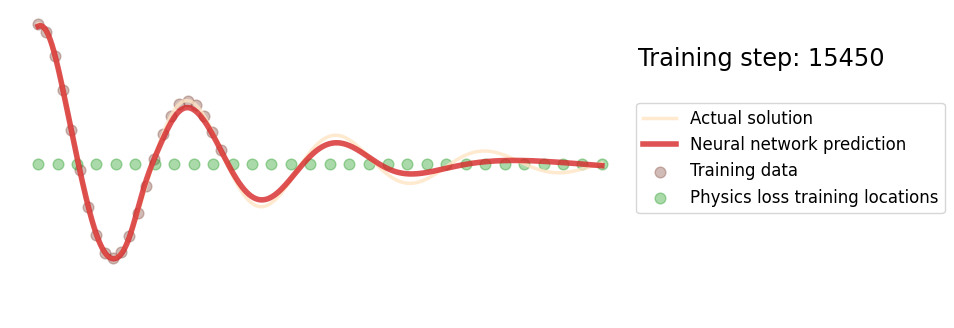

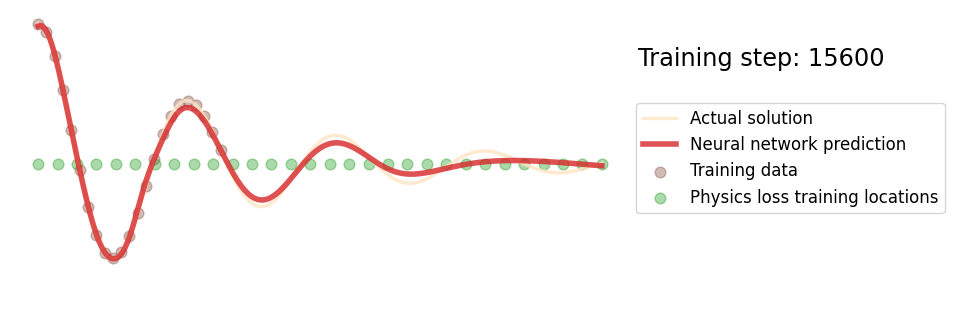

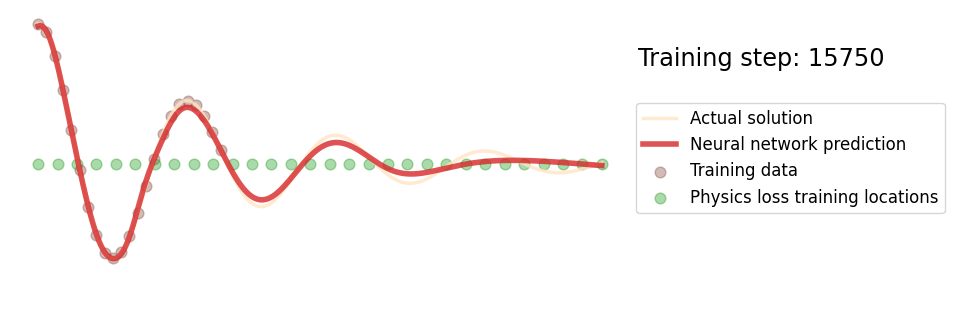

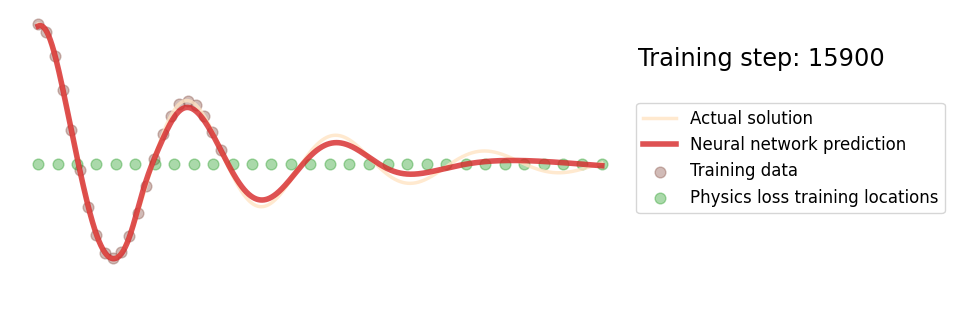

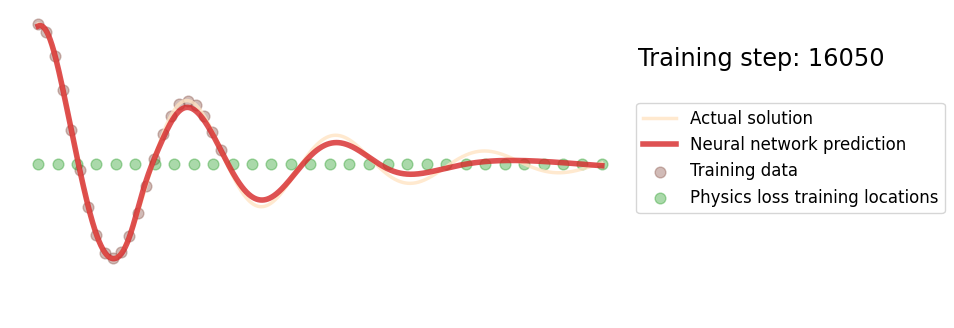

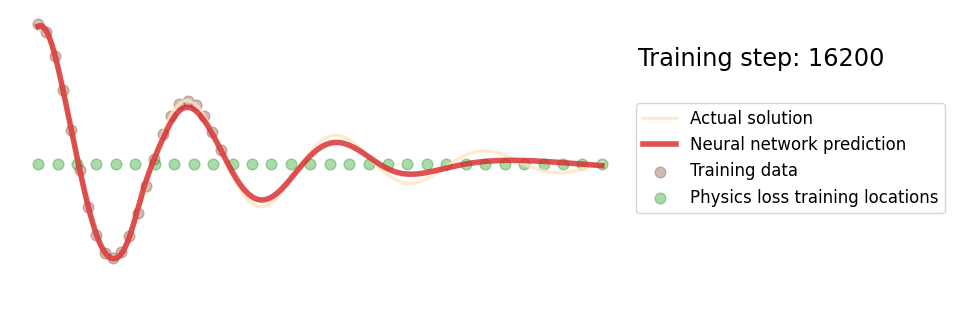

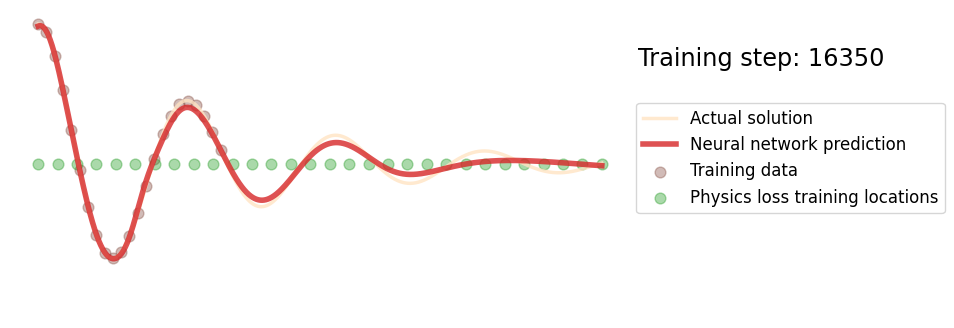

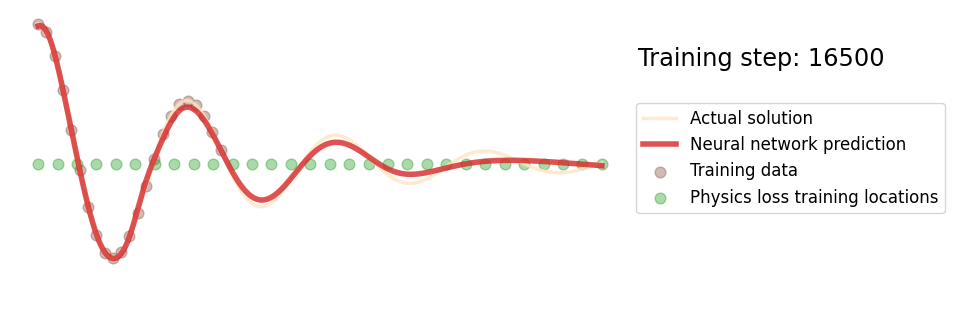

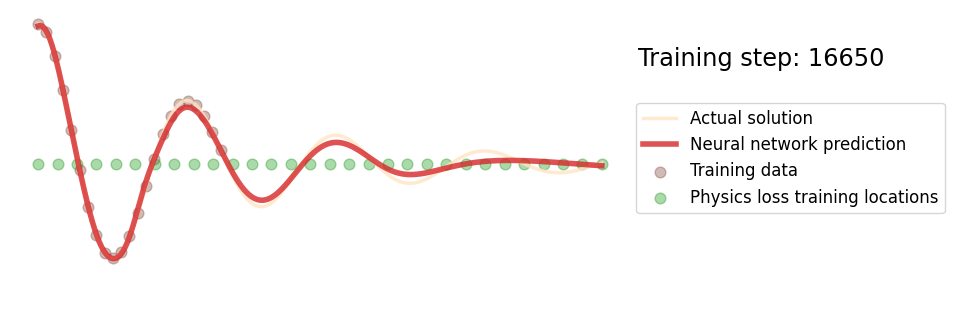

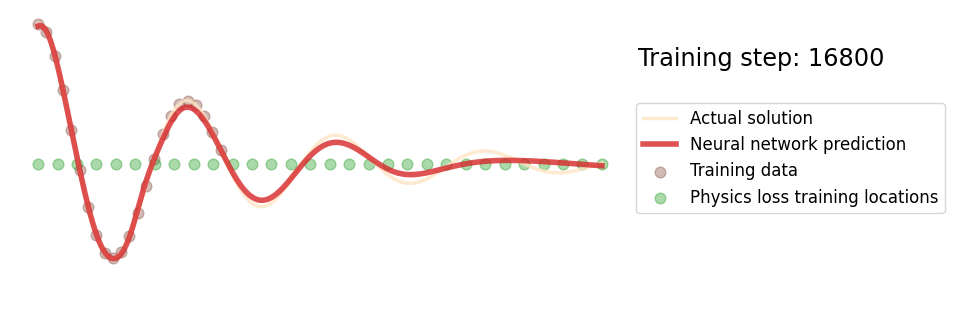

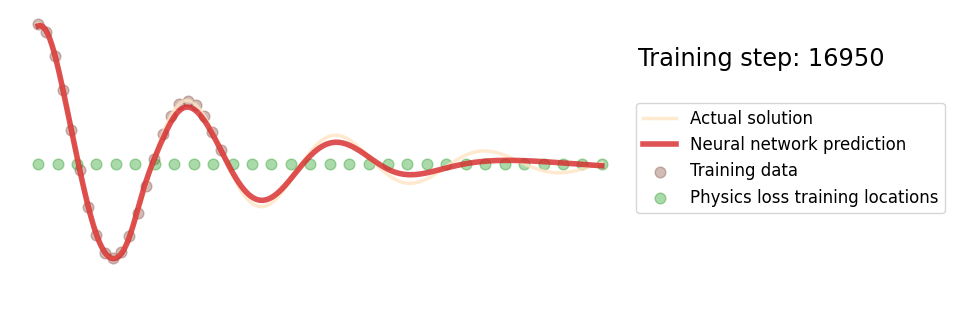

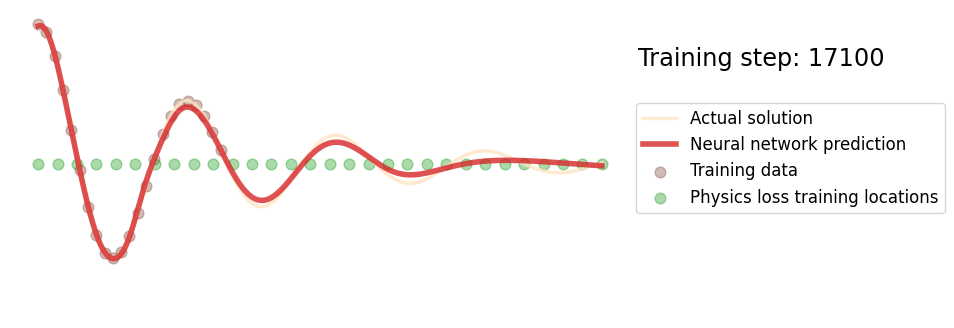

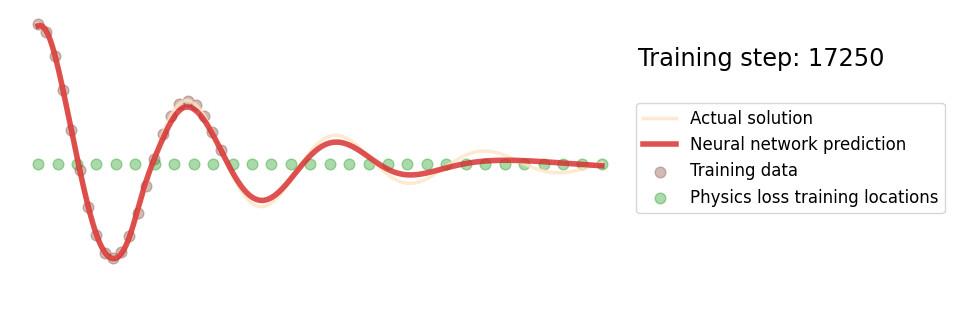

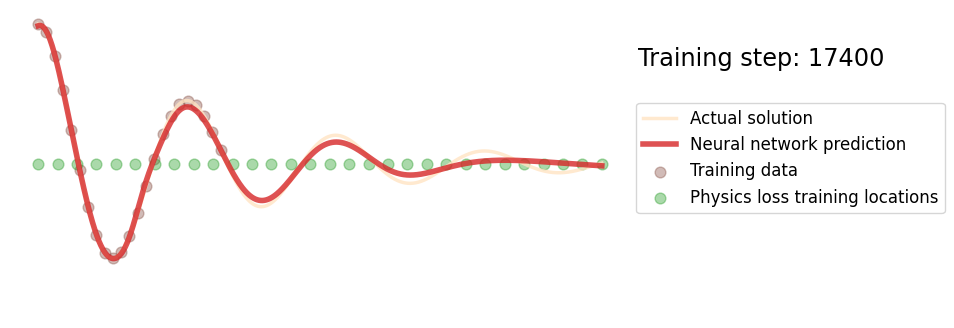

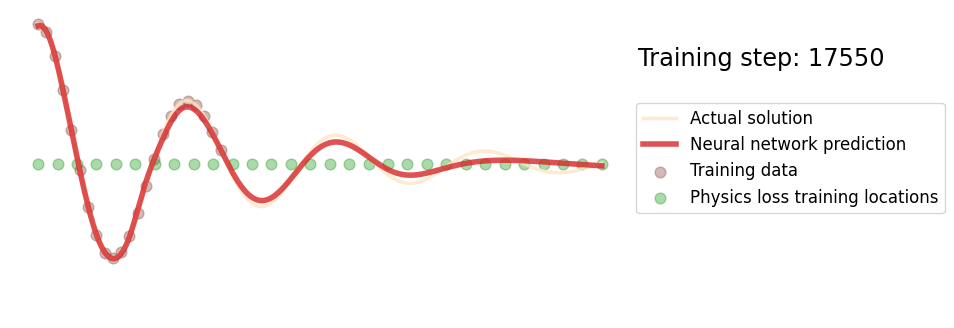

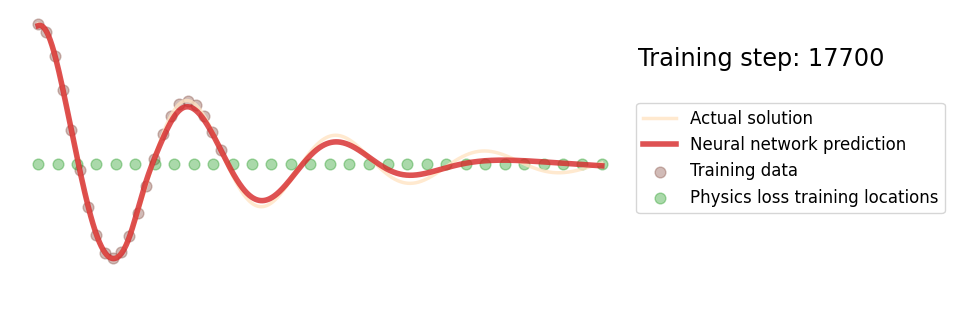

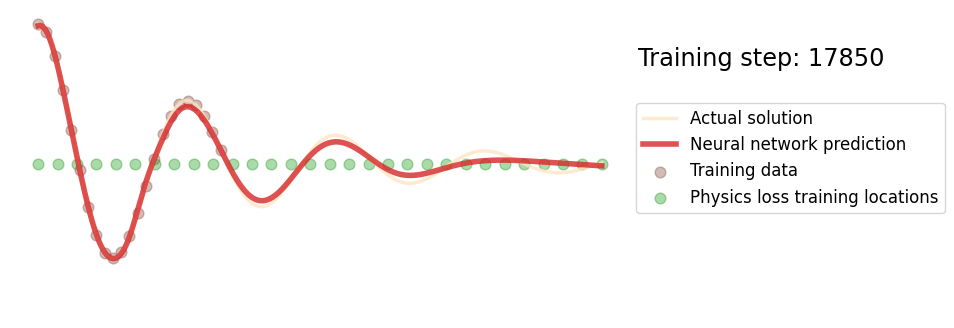

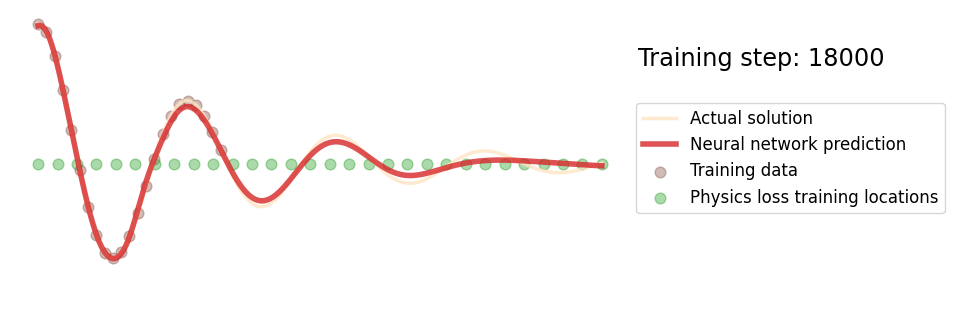

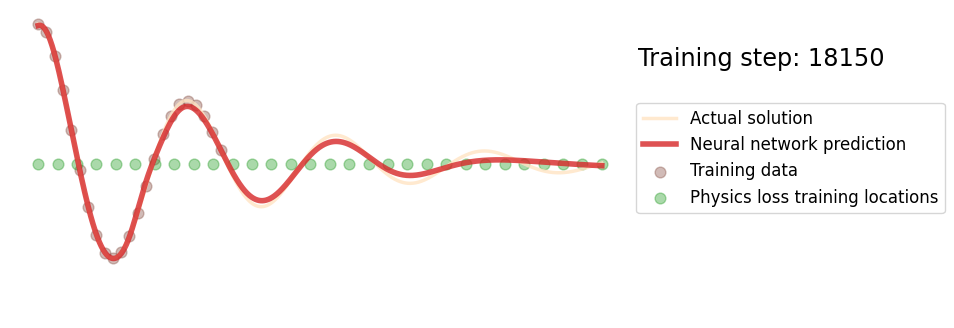

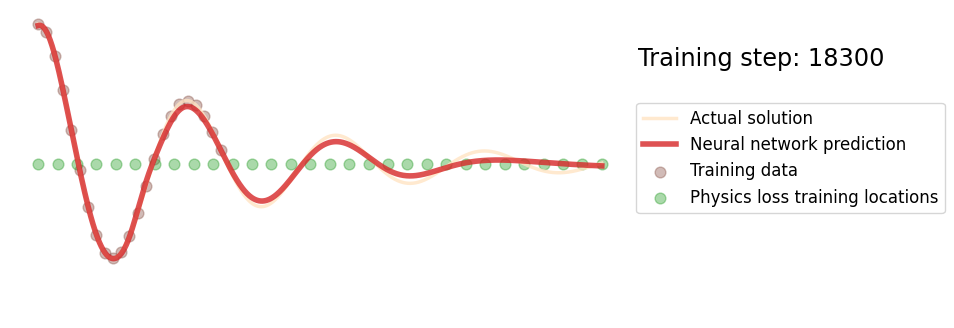

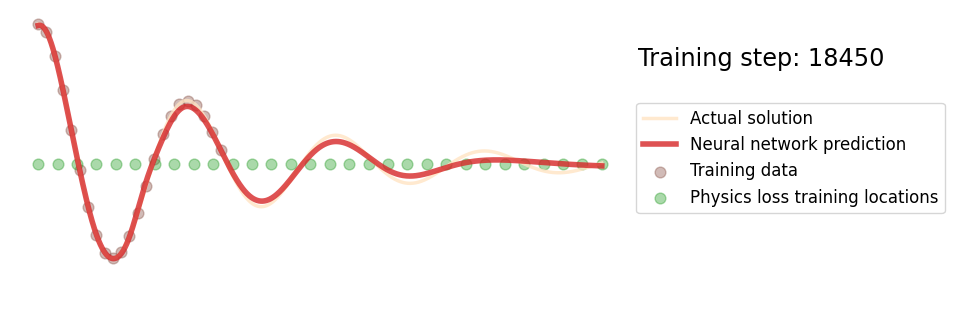

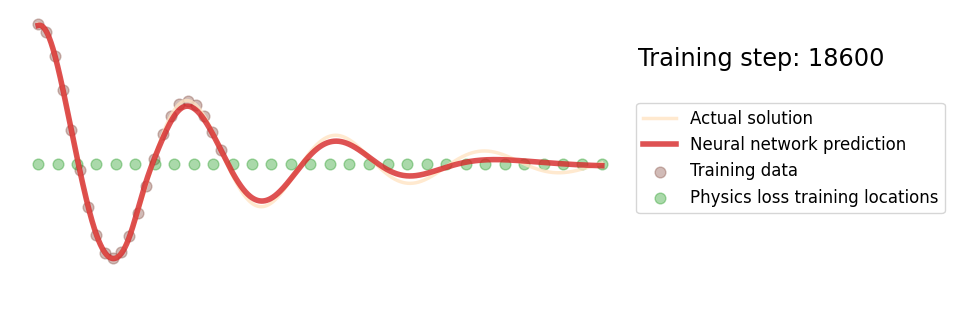

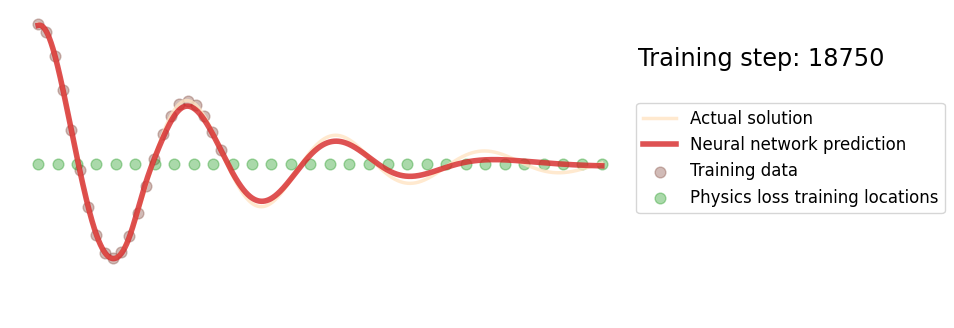

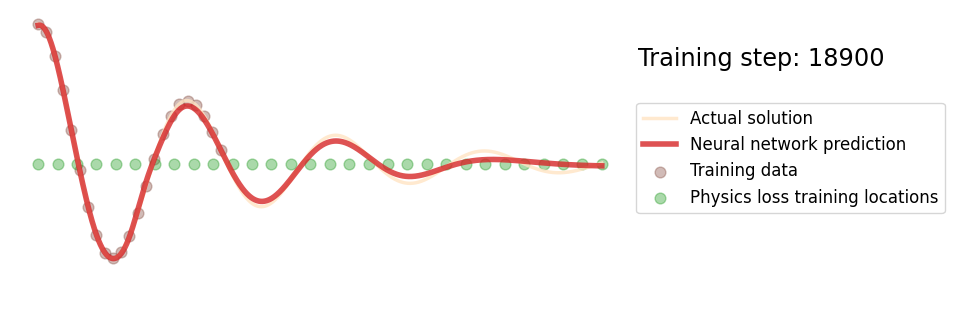

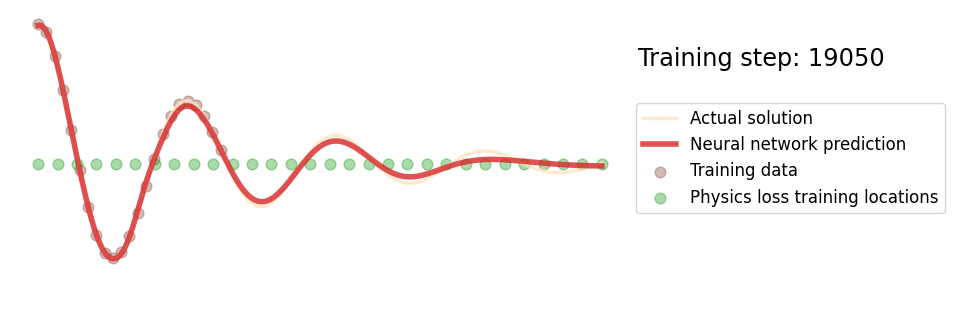

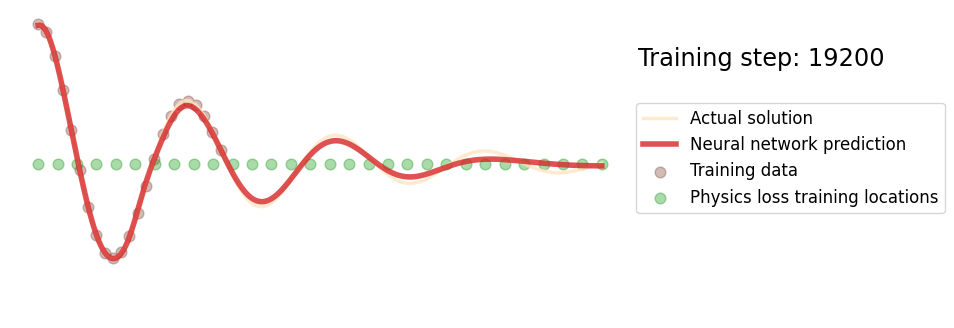

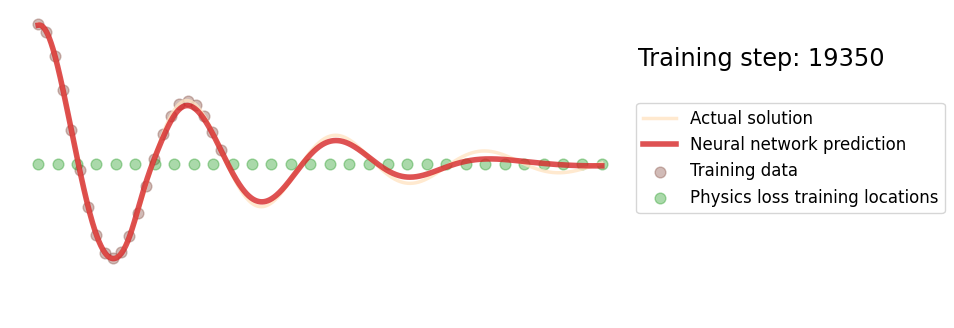

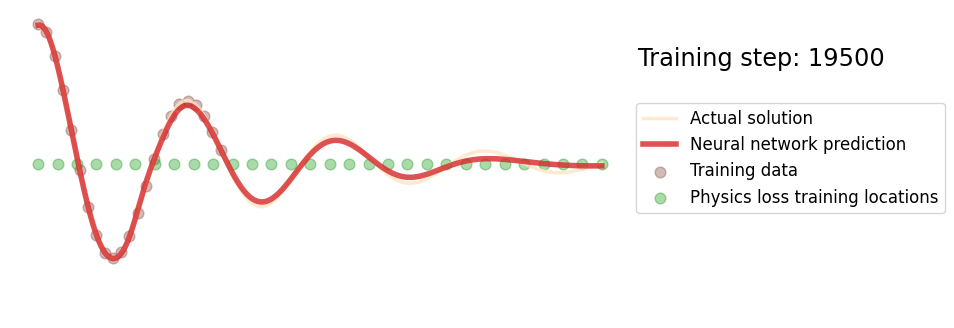

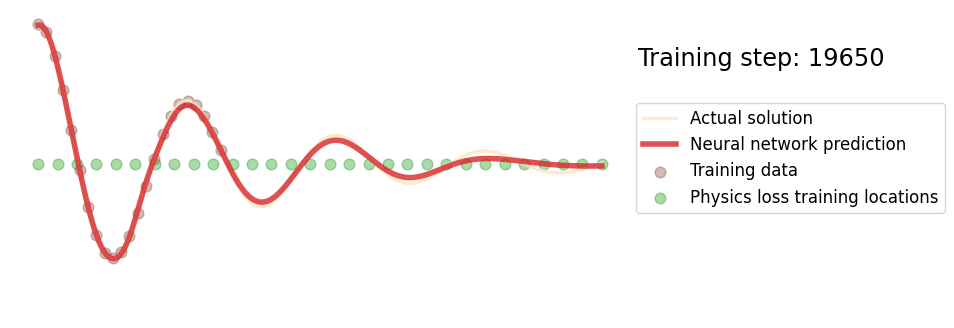

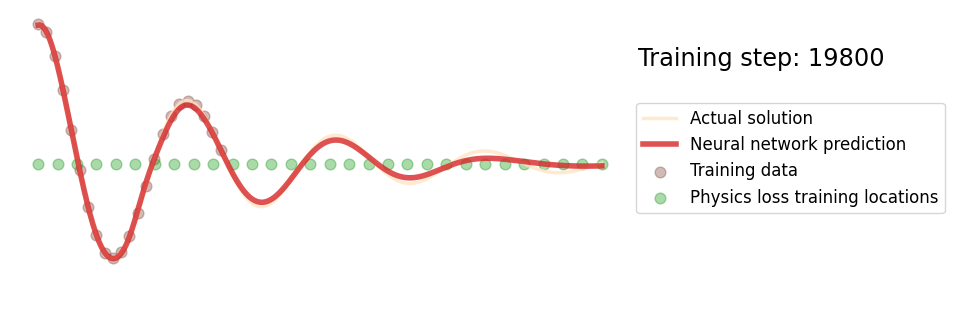

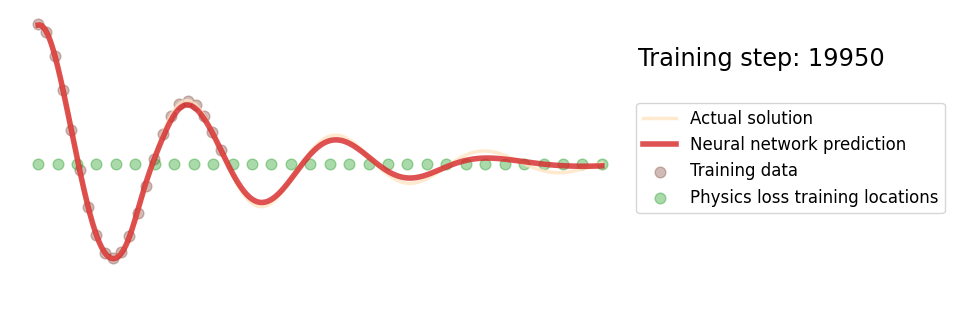

In [26]:
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True) # sample locations over the problem domain
mu, k = 2*d, w0**2     # In our case mu (damping coefficient) is 2*d = 6 , spring constant = 21*21 = 441

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)  # Used a standard learning rate of 1e - 4
for i in range(20000):
    optimizer.zero_grad()

    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error

    # compute the "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]           # computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]           # computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp
    # computes the residual of the 1D harmonic oscillator differential equation which is m*d²y/dx² + μ(dy/dx) + kx = 0 .
    loss2 = (1e-4)*torch.mean(physics**2)

    # backpropagate joint loss
    loss = loss1 + loss2     # add two loss terms together
    loss.backward()
    optimizer.step()


    # plot the result as training progresses
    if (i+1) % 150 == 0:
        yh = model(x).detach()
        xp = x_physics.detach()
        plot_result(x,y,x_data,y_data,yh,xp)

**<hr4 color="bisque" >This usage of PINNS can be extended to even multi block system problems in SHM . While it is easy to calculate the parameters , in a multi block system , when the damping is not considered , in real world scenario that's just not feasible . This is where the concept of using PINNS induced neural network can be of a significant advantage. Once we know the exact position of the object , it also becomes easy to map the energy loss ; which is of significant advantage again as well.  </hr>**

<hr color="bisque"> </hr>